## Imports and global variables

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.autograd import grad
from torch.optim import Adam
from qadence import QNN, QuantumCircuit, feature_map, hea, chain, Z
from qadence.types import BasisSet, ReuploadScaling
from qadence import add
from qadence.draw import display
from tqdm import trange, tqdm
from scipy.integrate import solve_ivp
from qadence import RX, RY
import math

In [2]:
torch.manual_seed(42)
np.random.seed(42)

### Feature maps

In [3]:
def make_feature_map(n_qubits: int, encoding: str = "cheb_tower", param: str = "x"):
    """
    Create a feature map circuit.

    Parameters
    ----------
    n_qubits : int
        Number of qubits to encode the input.
    encoding : str
        Type of encoding: currently supports "cheb_tower".
    param : str
        Name of the input parameter, e.g., "x"

    Returns
    -------
    QuantumCircuit
        A Qadence feature map circuit.
    """

    if encoding == "cheb_tower":
        #""""
        return feature_map(
            n_qubits=n_qubits,
            param=param,
            fm_type=BasisSet.CHEBYSHEV,
            reupload_scaling=ReuploadScaling.TOWER,
        )
        #"""

    raise ValueError(f"Unsupported encoding type: {encoding}")


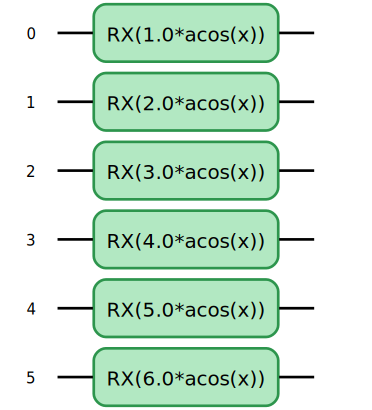

In [4]:
fmap = make_feature_map(n_qubits=6, encoding="cheb_tower")
display(fmap)

### Ansatz

In [5]:
def make_ansatz(n_qubits: int, depth: int, ansatz_type: str = "hea"):
    """
    Create a variational ansatz circuit.

    Parameters
    ----------
    n_qubits : int
        Number of qubits in the circuit.
    depth : int
        Number of layers (rotation + entangler blocks).
    ansatz_type : str
        Type of ansatz. Currently supports "hea".

    Returns
    -------
    QuantumCircuit
        A Qadence variational circuit.
    """

    if ansatz_type == "hea":
        return hea(n_qubits=n_qubits, depth=depth)

    raise ValueError(f"Unsupported ansatz type: {ansatz_type}")


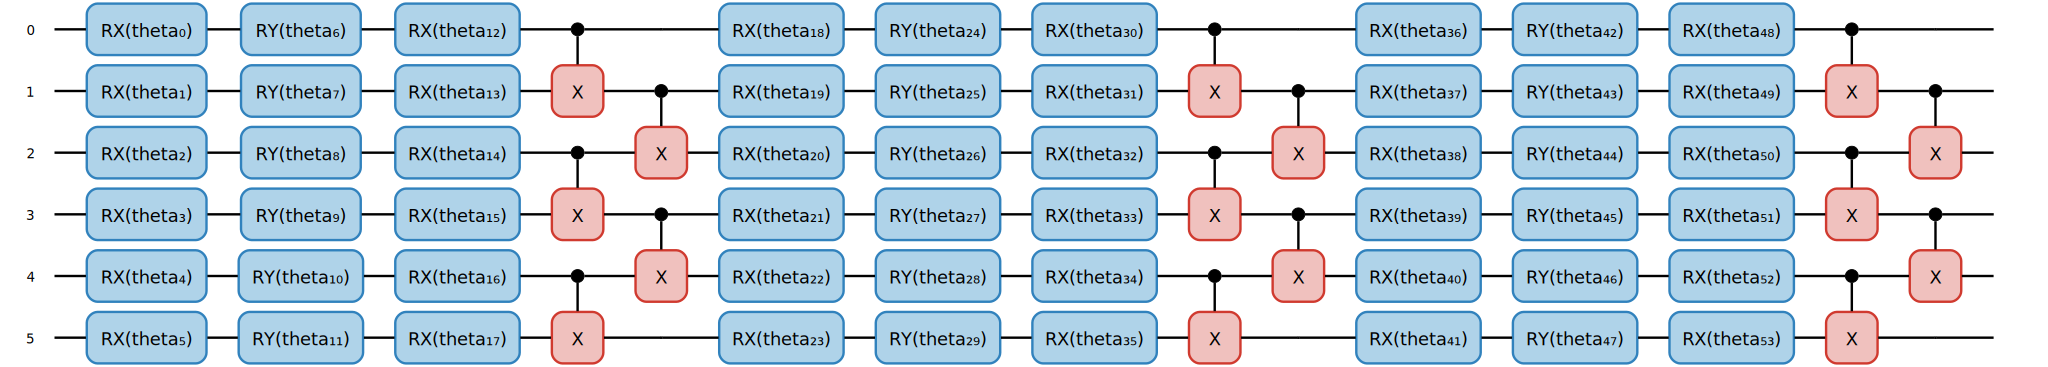

In [6]:
ansatz = make_ansatz(n_qubits=6, depth=3)
display(ansatz)


### Observable

In [7]:
def make_observable(n_qubits: int, observable_type: str = "total_magnetization"):
    """
    Generate the observable for QNN readout.

    Parameters
    ----------
    n_qubits : int
        Number of qubits in the circuit.
    observable_type : str
        Type of observable to construct. Currently supports:
        - "total_magnetization": sum of Z_i over all qubits

    Returns
    -------
    Observable (Expression)
    """
    if observable_type == "total_magnetization":
        return add(Z(i) for i in range(n_qubits))

    raise ValueError(f"Unsupported observable type: {observable_type}")


### Full QNN (circuit)

In [8]:
def make_model(fmap, ansatz, observable, n_qubits: int, input_params=["x"]):
    """
    Assemble the full QNN model.

    Parameters
    ----------
    fmap : QuantumCircuit
        Feature map circuit.
    ansatz : QuantumCircuit
        Variational ansatz circuit.
    observable : Expression
        Observable for readout.
    n_qubits : int
        Number of qubits.
    input_params : list
        Names of input variables, e.g., ["x"]

    Returns
    -------
    QNN
        Differentiable quantum neural network model.
    """
    circuit = QuantumCircuit(n_qubits, chain(fmap, ansatz))
    model = QNN(circuit=circuit, observable=observable, inputs=input_params)
    return model, circuit


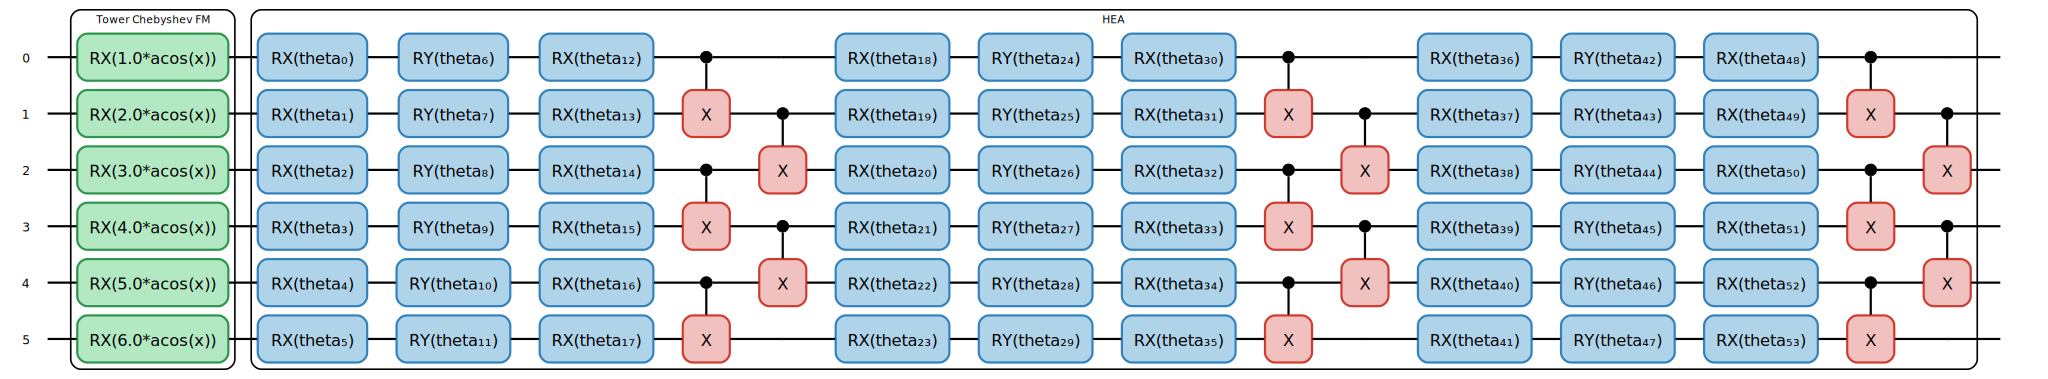

In [9]:
fmap = make_feature_map(n_qubits=6)
ansatz = make_ansatz(n_qubits=6, depth=3)
observable = make_observable(n_qubits=6)

model, circuit = make_model(fmap, ansatz, observable, n_qubits=6)

display(circuit)


### Training grid (helper) + Training loop

In [10]:
def make_training_grid(n_points: int, xmin: float, xmax: float, requires_grad=True):
    """
    Generate training input values in [xmin, xmax].

    Returns a tensor of shape (n_points, 1) with gradients enabled.
    """
    x_train = xmin + (xmax - xmin) * torch.rand(n_points, 1)
    x_train.requires_grad_(requires_grad)
    return x_train


In [275]:
def train_and_log(
        model,
        loss_fn,
        n_epochs=250,
        n_points=30,
        xmin=-0.99,
        xmax=0.99,
        lr=0.1,
        stop_threshold=1e-3,
        plateau_patience=10,
        min_lr=1e-7,
        clip_th=0.25,
        scheduler_eps=1e-10,
):
    """
    Train model and log losses only (no predictions). Use test data later for plotting.

    Returns
    -------
    model : QNN
        Trained model
    history : dict
        Contains 'losses' and training config
    """

    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=plateau_patience, factor=0.5, eps=scheduler_eps
    )

    losses = []
    theta_log = []

    progress = trange(n_epochs, desc="Training", dynamic_ncols=True)

    for epoch in progress:
        optimizer.zero_grad()
        x_train = make_training_grid(n_points, xmin, xmax, requires_grad=True)
        loss = loss_fn(model, x_train)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_th)
        optimizer.step()

        loss_val = loss.item()
        scheduler.step(loss_val)
        current_lr = optimizer.param_groups[0]['lr']

        losses.append(loss_val)
        theta_log.append([p.detach().cpu().numpy().copy() for p in model.parameters()])


        progress.set_postfix(loss=loss_val, lr=current_lr)

        # ─── Stopping Criteria ────────────────────────────────────────────

        # (1) loss below threshold
        if loss_val < stop_threshold:
            print(f"\n Early stopping at epoch {epoch} — loss < {stop_threshold:.1e}")
            break

        # (2) learning rate too small
        if current_lr < min_lr:
            print(f"\n Stopping at epoch {epoch} — learning rate below {min_lr}")
            break


    history = {
        "losses": losses,
        "thetas": theta_log,
        "xmin": xmin,
        "xmax": xmax,
        "n_epochs": epoch + 1
    }
    return model, history


### Simple ODE Example [u(x)=exp(-x), u(0)=1]

In [331]:
def make_loss_fn():
    """
    Loss for du/dx + u = 0 with boundary u(0) = 1 (pinned).
    """
    def loss_fn(model, x):
        u = model(x)
        du_dx = grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        ode_residual = du_dx + u
        ode_loss = torch.mean(ode_residual**2)

        # Pinned boundary loss
        x0 = torch.tensor([[0.0]], requires_grad=True)
        u0 = model(x0)
        boundary_loss = (u0 - 1.0)**2

        return ode_loss + boundary_loss

    return loss_fn


In [332]:
def f_exact(x_tensor):
    return torch.exp(-x_tensor)

def plot_results(model, history, step=0.01):
    # Generate test grid
    x_test = torch.arange(history["xmin"], history["xmax"], step).unsqueeze(1)
    y_exact = f_exact(x_test).flatten()
    y_model = model(x_test).detach().flatten()

    # Plot function comparison
    plt.figure(figsize=(6, 4))
    plt.plot(x_test.numpy(), y_exact.numpy(), label="Exact $e^{-x}$", linewidth=2)
    plt.plot(x_test.numpy(), y_model.numpy(), label="QNN prediction", linestyle="--")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.title("QNN vs Exact Solution")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot training loss
    plt.figure(figsize=(6, 4))
    plt.semilogy(history["losses"], label="Training loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (log scale)")
    plt.title("Training Loss Curve")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Training:  22%|██▏       | 111/500 [00:02<00:09, 41.27it/s, loss=0.000999, lr=0.00625]



 Early stopping at epoch 111 — loss < 1.0e-03


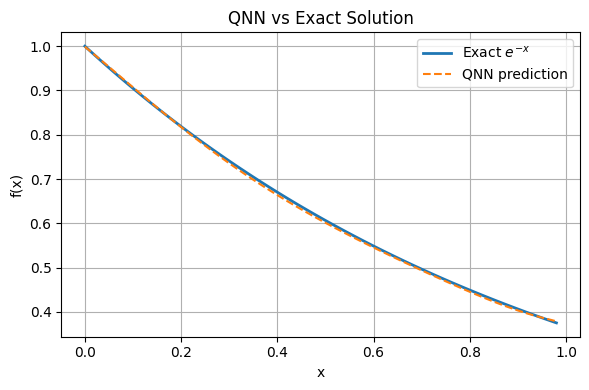

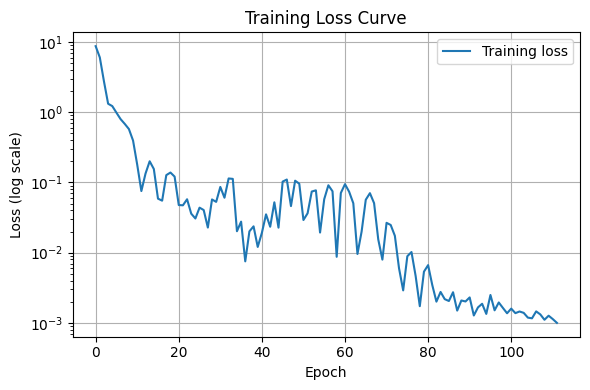

In [333]:
# ─── 1. Set model hyperparameters ─────────────────────────────
n_qubits = 3
depth = 3
encoding = "cheb_tower"

# ─── 2. Build components ──────────────────────────────────────
fmap = make_feature_map(n_qubits=n_qubits, encoding=encoding)
ansatz = make_ansatz(n_qubits=n_qubits, depth=depth)
observable = make_observable(n_qubits=n_qubits)
model, circuit = make_model(fmap, ansatz, observable, n_qubits)


# ─── 3. Train the model ───────────────────────────────────────
loss_fn = make_loss_fn()
trained_model, history = train_and_log(
    model, loss_fn,
    n_epochs=500,
    n_points=1000,
    xmin=0.0,
    xmax=0.99,
    lr=0.1,
    stop_threshold=1e-3,
    plateau_patience=10,
    min_lr=1e-8
)

# ─── 4. Plot the results ──────────────────────────────────────
plot_results(trained_model, history)
model_lin = trained_model
lin_history = history


### Another simple ODE Example (df/dx = 5(4x^3 + x^2 - 2x - 0.5), f(0) = 0)

In [ ]:
def make_loss_fn():
    """
    Loss for the ODE: df/dx = 5(4x^3 + x^2 - 2x - 0.5), with f(0) = 0
    """
    def dfdx_exact(x):
        return 5 * (4 * x**3 + x**2 - 2 * x - 0.5)

    def loss_fn(model, x):
        f = model(x)
        dfdx_model = torch.autograd.grad(
            f, x,
            grad_outputs=torch.ones_like(f),
            create_graph=True
        )[0]
        dfdx_true = dfdx_exact(x)
        loss_ode = torch.mean((dfdx_model - dfdx_true)**2)

        # Boundary condition f(0) = 0
        x0 = torch.tensor([[0.0]], requires_grad=True)
        f0 = model(x0)
        loss_bc = (f0 - 0.0)**2

        return loss_ode + loss_bc

    return loss_fn

def f_exact2(x):
    return 5 * (x**4 + (1/3) * x**3 - x**2 - 0.5 * x)



In [342]:
def plot_tutorial_result(model, history, f_exact_func, step=0.01):
    x_test = torch.arange(history["xmin"], history["xmax"], step).unsqueeze(1)
    y_model = model(x_test).detach().flatten()
    y_exact = f_exact_func(x_test).flatten()

    # Plot prediction
    plt.figure()
    plt.plot(x_test.numpy(), y_exact.numpy(), label="Exact solution", linewidth=2)
    plt.plot(x_test.numpy(), y_model.numpy(), "--", label="Trained model")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.title("QNN vs Exact")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot loss
    plt.figure()
    plt.semilogy(history["losses"], label="Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (log scale)")
    plt.title("Training Loss")
    plt.grid(True)
    plt.legend()
    plt.show()


In [343]:
# Model setup
n_qubits = 3
depth = 3
encoding = "cheb_tower"

fmap = make_feature_map(n_qubits, encoding)
ansatz = make_ansatz(n_qubits, depth)
observable = make_observable(n_qubits)
model, circuit = make_model(fmap, ansatz, observable, n_qubits)


In [344]:
loss_fn = make_loss_fn()
trained_model, history = train_and_log(
    model, loss_fn,
    n_epochs=250,
    n_points=20,
    xmin=-0.99,
    xmax=0.99,
    lr=0.1,
    stop_threshold=1e-4,
    plateau_patience=20,
)

model_poly = trained_model
poly_history= history


Training: 100%|██████████| 250/250 [00:04<00:00, 52.97it/s, loss=0.00213, lr=0.00313] 


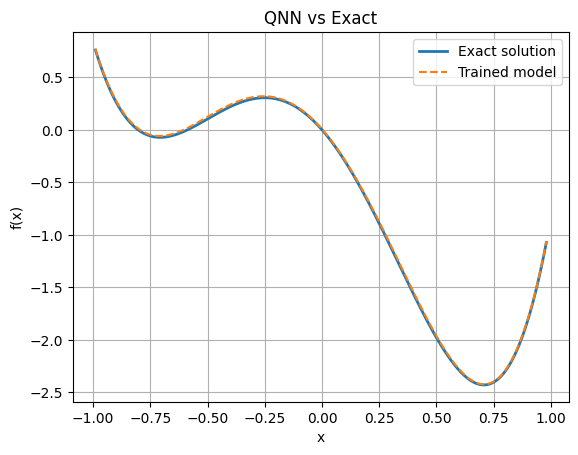

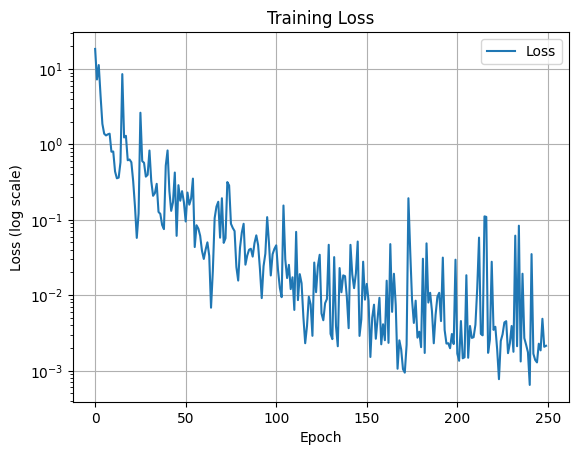

In [345]:
plot_tutorial_result(trained_model, history, f_exact)

### Replicate results from the paper (A. Differential equation example)

In [20]:
def make_loss_fn_case_a_floating(lambda_: float = 8.0, kappa: float = 0.1):
    """
    Floating boundary version of the Case A loss function.
    Solves: du/dx + λ(κ + tan(λx)) u(x) = 0
    Enforces u(0) = 1 by shifting the model output.
    """
    def loss_fn(model, x):
        u_raw = model(x)

        # Floating shift to satisfy u(0) = 1
        x0 = torch.tensor([[0.0]], requires_grad=True)
        u0 = model(x0)
        shift = 1.0 - u0

        u = u_raw + shift

        du_dx = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            create_graph=True
        )[0]

        residual = du_dx + lambda_ * (kappa + torch.tan(lambda_ * x)) * u
        return torch.mean(residual**2)

    return loss_fn


def f_exact_case_a(x_tensor, lambda_=8.0, kappa=0.1):
    return torch.exp(-kappa * lambda_ * x_tensor) * torch.cos(lambda_ * x_tensor)


In [21]:
def plot_case_a_with_exact(model, lambda_=8.0, kappa=0.1):
    x_test = torch.linspace(0.0, 0.9, 200).unsqueeze(1)
    with torch.no_grad():
        y_model = model(x_test).flatten()
        x0 = torch.tensor([[0.0]])
        shift = 1.0 - model(x0).item()
        y_model_shifted = y_model + shift

    y_exact = f_exact_case_a(x_test, lambda_, kappa).flatten()

    plt.figure()
    plt.plot(x_test.numpy().flatten(), y_exact.numpy(), label="Exact solution", linewidth=2)
    plt.plot(x_test.numpy().flatten(), y_model_shifted.numpy(), "--", label="QNN prediction")
    plt.xlabel("x")
    plt.ylabel("u(x)")
    plt.title("QNN vs Exact Solution")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



def plot_loss_curve(history):
    plt.figure()
    plt.semilogy(history["losses"], label="Training loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (log scale)")
    plt.title("Training Loss")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Training:  35%|███▌      | 529/1500 [01:47<03:17,  4.92it/s, loss=0.000968, lr=3.91e-5]



 Early stopping at epoch 529 — loss < 1.0e-03


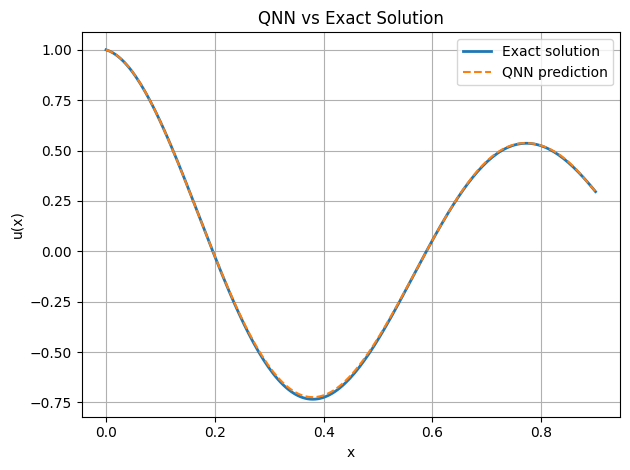

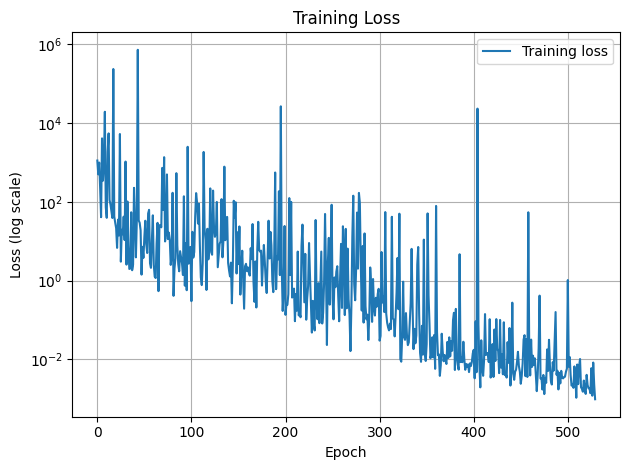

In [22]:
# Parameters from paper
n_qubits = 6
depth = 16
encoding = "cheb_tower"
lambda_ = 8.0
kappa = 0.1

# Build circuit
fmap = make_feature_map(n_qubits=n_qubits, encoding=encoding)
ansatz = make_ansatz(n_qubits=n_qubits, depth=depth)
observable = make_observable(n_qubits=n_qubits)
model, circuit = make_model(fmap, ansatz, observable, n_qubits)

# Floating loss
loss_fn = make_loss_fn_case_a_floating(lambda_, kappa)

# Train (on Chebyshev domain, sparse points)
trained_model, history = train_and_log(
    model, loss_fn,
    n_epochs=1500,
    n_points=50,
    xmin=0.0,
    xmax=0.9,
    lr=0.01,
    stop_threshold=1e-3,
    plateau_patience=25,
    min_lr=1e-9
)

# Plot
plot_case_a_with_exact(trained_model, lambda_, kappa)
plot_loss_curve(history)

case_a_qnn_model = trained_model
case_a_history = history


#### Regularization for Case A (try)

In [23]:
def make_regularized_loss(base_loss_fn, x_reg, u_reg, n_iter, schedule="linear", ndrop=0.3, delta=0.1):
    """
    Returns a loss function with regularization added.

    Parameters
    ----------
    base_loss_fn : callable
        Original loss function, taking model and x.
    x_reg : torch.Tensor
        Regularization input points (R x 1).
    u_reg : torch.Tensor
        Corresponding target values (R x 1).
    n_iter : int
        Maximum training iterations.
    schedule : str
        "linear" or "sigmoid"
    ndrop : float
        Drop point as fraction of n_iter (used only for sigmoid).
    delta : float
        Transition rate for sigmoid schedule.
    """
    def zeta(nj):
        if schedule == "linear":
            return 1.0 - nj / n_iter
        elif schedule == "sigmoid":
            return 1.0 - np.tanh((nj - ndrop * n_iter) / (delta * n_iter))
        else:
            raise ValueError(f"Unsupported schedule: {schedule}")

    def loss_fn(model, x, epoch):
        loss_main = base_loss_fn(model, x)
        y_pred = model(x_reg)
        loss_reg = torch.mean((y_pred - u_reg) ** 2)
        total_loss = loss_main + zeta(epoch) * loss_reg
        return total_loss

    return loss_fn


In [24]:
def train_and_log_regularized(
        model,
        loss_fn,
        n_epochs=250,
        n_points=30,
        xmin=-0.99,
        xmax=0.99,
        lr=0.1,
        stop_threshold=1e-3,
        plateau_patience=10,
        min_lr=1e-7,
        clip_th=0.25,
        scheduler_eps=1e-10
):
    """
    Train model with regularization-aware loss_fn(model, x, epoch).
    Returns model and training history.
    """
    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=plateau_patience, factor=0.5, eps=scheduler_eps
    )

    losses = []

    progress = trange(n_epochs, desc="Training", dynamic_ncols=True)

    for epoch in progress:
        optimizer.zero_grad()
        x_train = make_training_grid(n_points, xmin, xmax, requires_grad=True)
        loss = loss_fn(model, x_train, epoch)  # pass epoch explicitly
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_th)
        optimizer.step()

        loss_val = loss.item()
        scheduler.step(loss_val)
        current_lr = optimizer.param_groups[0]['lr']

        losses.append(loss_val)
        progress.set_postfix(loss=loss_val, lr=current_lr)

        if loss_val < stop_threshold:
            print(f"\nEarly stopping at epoch {epoch} — loss < {stop_threshold:.1e}")
            break
        if current_lr < min_lr:
            print(f"\nStopping at epoch {epoch} — learning rate below {min_lr}")
            break

    history = {
        "losses": losses,
        "xmin": xmin,
        "xmax": xmax,
        "n_epochs": epoch + 1
    }
    return model, history


Training:  28%|██▊       | 413/1500 [04:09<10:57,  1.65it/s, loss=0.000887, lr=7.81e-5]



Early stopping at epoch 413 — loss < 1.0e-03


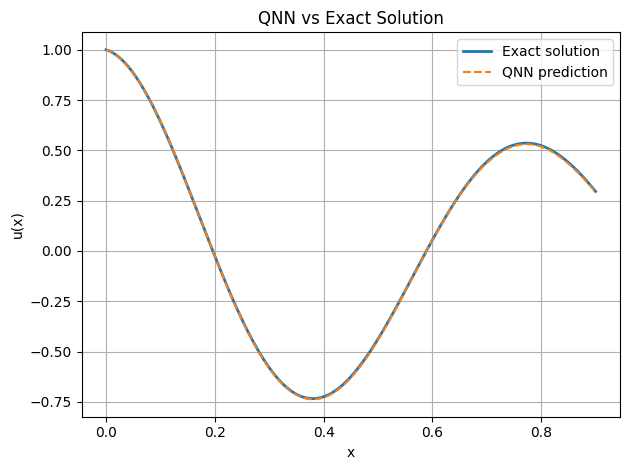

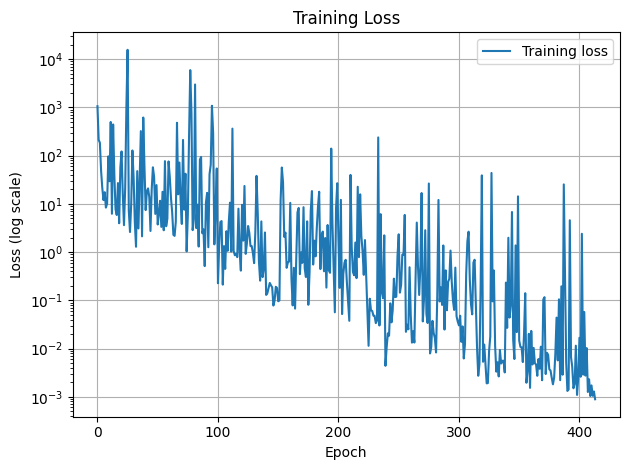

In [25]:
# Parameters from paper
n_qubits = 6
depth = 32
encoding = "cheb_tower"
lambda_ = 8.0
kappa = 0.1

# Build circuit
fmap = make_feature_map(n_qubits=n_qubits, encoding=encoding)
ansatz = make_ansatz(n_qubits=n_qubits, depth=depth)
observable = make_observable(n_qubits=n_qubits)
model, circuit = make_model(fmap, ansatz, observable, n_qubits)

# Setup regularization points near the boundary
x_reg = torch.tensor([[0.0], [0.5], [0.1], [0.15], [0.45], [0.75], [0.8], [0.85],[0.9]], dtype=torch.float32, requires_grad=True)
u_reg = f_exact_case_a(x_reg, lambda_, kappa).detach()

# Wrap the loss function to include regularization
loss_fn = make_regularized_loss(
    base_loss_fn=make_loss_fn_case_a_floating(lambda_, kappa),
    x_reg=x_reg,
    u_reg=u_reg,
    n_iter=250,
    schedule="sigmoid",  # or "linear"
    ndrop=0.3,
    delta=0.05
)

# Train
trained_model, history = train_and_log_regularized(
    model, loss_fn,
    n_epochs=1500,
    n_points=20,
    xmin=0.0,
    xmax=0.9,
    lr=0.01,
    stop_threshold=1e-3,
    plateau_patience=25,
    min_lr=1e-9
)

# Plot
plot_case_a_with_exact(trained_model, lambda_, kappa)
plot_loss_curve(history)

case_a_qnn_model_reguralised = trained_model


#### Case B (lambda=20.0)

Training: 100%|██████████| 1500/1500 [42:04<00:00,  1.68s/it, loss=3.18, lr=1.19e-9]   


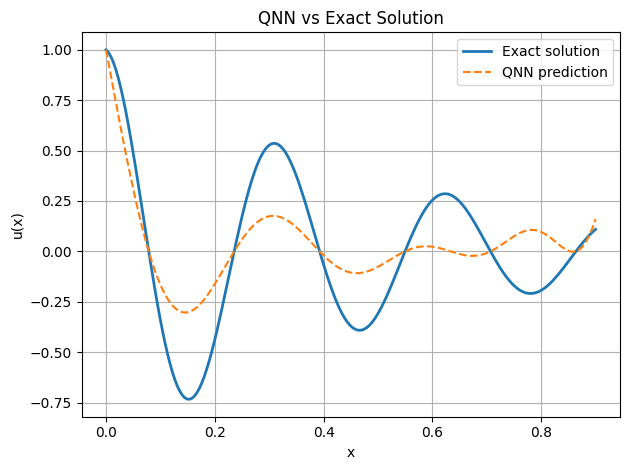

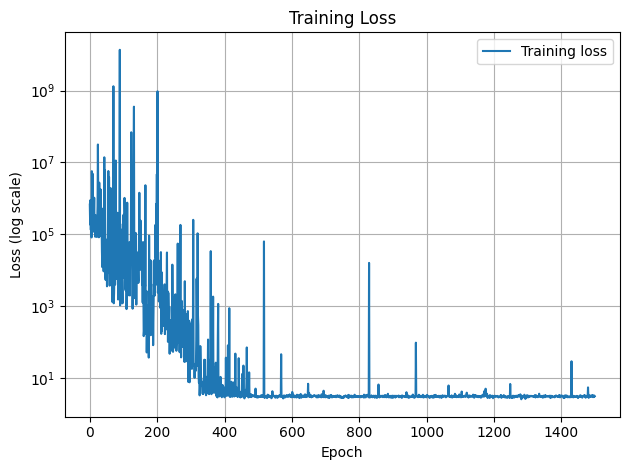

In [26]:
# Parameters from paper
n_qubits = 6
depth = 16
encoding = "cheb_tower"
lambda_ = 20.0
kappa = 0.1

# Build circuit
fmap = make_feature_map(n_qubits=n_qubits, encoding=encoding)
ansatz = make_ansatz(n_qubits=n_qubits, depth=depth)
observable = make_observable(n_qubits=n_qubits)
model, circuit = make_model(fmap, ansatz, observable, n_qubits)

# Floating loss
loss_fn = make_loss_fn_case_a_floating(lambda_, kappa)

# Train
trained_model, history = train_and_log(
    model, loss_fn,
    n_epochs=1500,
    n_points=10000,
    xmin=0.0,
    xmax=0.9,
    lr=0.01,
    stop_threshold=1e-3,
    plateau_patience=25,
    min_lr=1e-9,
    clip_th=0.25,
    scheduler_eps=1e-9
)

# Plot
plot_case_a_with_exact(trained_model, lambda_, kappa)
plot_loss_curve(history)

case_b_qnn_model_lambda20 = trained_model
case_a_20_history = history


Training: 100%|██████████| 1500/1500 [06:31<00:00,  3.83it/s, loss=7.61, lr=1.19e-9]   


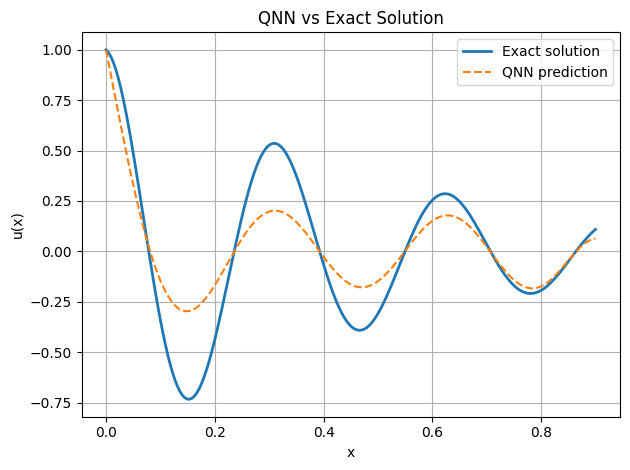

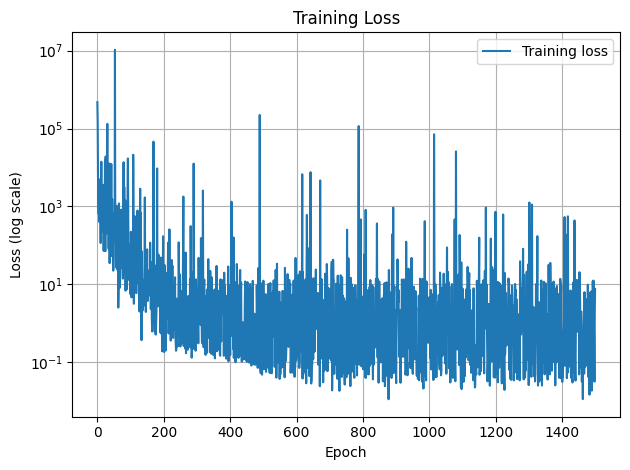

In [27]:
# Parameters from paper
n_qubits = 6
depth = 16
encoding = "cheb_tower"
lambda_ = 20.0
kappa = 0.1

# Build circuit
fmap = make_feature_map(n_qubits=n_qubits, encoding=encoding)
ansatz = make_ansatz(n_qubits=n_qubits, depth=depth)
observable = make_observable(n_qubits=n_qubits)
model, circuit = make_model(fmap, ansatz, observable, n_qubits)

# Setup regularization points near the boundary
x_reg = torch.arange(0.0, 0.91, 0.5).unsqueeze(1).requires_grad_()
u_reg = f_exact_case_a(x_reg, lambda_, kappa).detach()

# Wrap the loss function to include regularization
loss_fn = make_regularized_loss(
    base_loss_fn=make_loss_fn_case_a_floating(lambda_, kappa),
    x_reg=x_reg,
    u_reg=u_reg,
    n_iter=1500,
    schedule="sigmoid",  # or "linear"
    ndrop=0.3,
    delta=0.05
)

# Train
trained_model, history = train_and_log_regularized(
    model, loss_fn,
    n_epochs=1500,
    n_points=10,
    xmin=0.0,
    xmax=0.9,
    lr=0.01,
    stop_threshold=1e-2,
    plateau_patience=25,
    min_lr=1e-9,
    clip_th=0.25,
    scheduler_eps=1e-9
)

# Plot
plot_case_a_with_exact(trained_model, lambda_, kappa)
plot_loss_curve(history)

case_b_qnn_model_lambda20_ = trained_model


### Replicate results from the paper (B. Differential equation with highly nontrivial dynamics)

In [28]:
def make_loss_fn_case_b_floating():
    """
    Floating boundary version for Case B (Eq. 32).
    Enforces u(0) = 0.75 by shifting the model output.
    """
    def loss_fn(model, x):
        u_raw = model(x)

        # Floating shift to satisfy u(0) = 0.75
        x0 = torch.tensor([[0.0]], requires_grad=True)
        u0 = model(x0)
        shift = 0.75 - u0

        u = u_raw + shift

        du_dx = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            create_graph=True
        )[0]

        residual = du_dx - 4 * u + 6 * u**2 - torch.sin(50 * x) - u * torch.cos(25 * x) + 0.5
        return torch.mean(residual ** 2)

    return loss_fn

def f_exact_case_b(x_tensor):
    """
    Solve Eq. (32) numerically:
    du/dx = 4u - 6u² + sin(50x) + u cos(25x) - 0.5
    with u(0) = 0.75
    """
    def rhs(x, u):
        return 4 * u - 6 * u**2 + np.sin(50 * x) + u * np.cos(25 * x) - 0.5

    x_eval = x_tensor.detach().cpu().numpy().flatten()
    sol = solve_ivp(rhs, [x_eval[0], x_eval[-1]], [0.75], t_eval=x_eval, method="RK45")
    return torch.tensor(sol.y[0], dtype=torch.float32)

In [29]:
def plot_case_b_with_exact(model):
    x_test = torch.linspace(0.0, 0.9, 200).unsqueeze(1)
    with torch.no_grad():
        y_model = model(x_test).flatten()
        x0 = torch.tensor([[0.0]])
        shift = 0.75 - model(x0).item()
        y_model_shifted = y_model + shift

    y_exact = f_exact_case_b(x_test).flatten()

    plt.figure()
    plt.plot(x_test.numpy().flatten(), y_exact.numpy(), label="Exact solution", linewidth=2)
    plt.plot(x_test.numpy().flatten(), y_model_shifted.numpy(), "--", label="QNN prediction")
    plt.xlabel("x")
    plt.ylabel("u(x)")
    plt.title("Case B: QNN vs Exact Solution")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Training: 100%|██████████| 500/500 [21:07<00:00,  2.53s/it, loss=9.85e-5, lr=7.81e-5]  


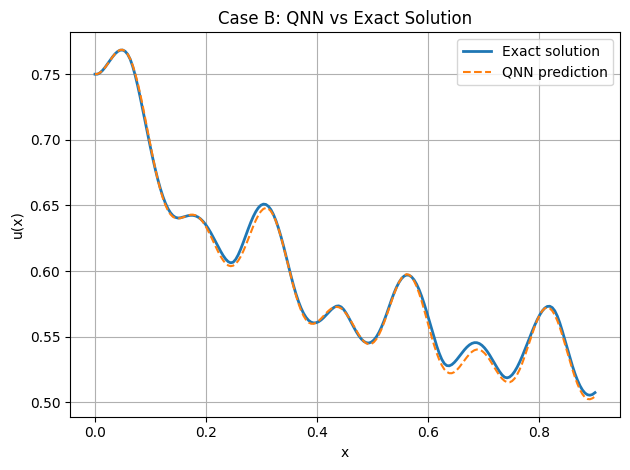

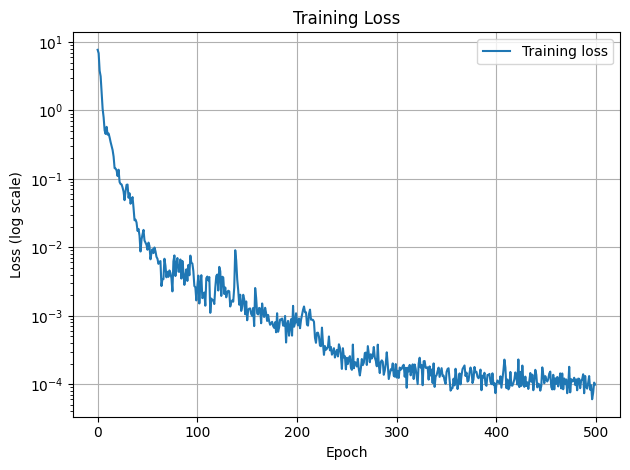

In [30]:
# Parameters from paper
n_qubits = 12
depth = 5
encoding = "cheb_tower"

# Build circuit
fmap = make_feature_map(n_qubits=n_qubits, encoding=encoding)
ansatz = make_ansatz(n_qubits=n_qubits, depth=depth)
observable = make_observable(n_qubits=n_qubits)
model, circuit = make_model(fmap, ansatz, observable, n_qubits)

# Loss
loss_fn = make_loss_fn_case_b_floating()

# Train
trained_model, history = train_and_log(
    model, loss_fn,
    n_epochs=500,
    n_points=100,
    xmin=0.0,
    xmax=0.9,
    lr=0.01,
    stop_threshold=1e-5,
    plateau_patience=25,
    min_lr=1e-9,
    clip_th=0.25,
    scheduler_eps=1e-9
)

# Plot
plot_case_b_with_exact(trained_model)
plot_loss_curve(history)

case_b_qnn_model = trained_model
case_b_history = history


### Replicate results from the paper (C. Strongly coupled equations)

In [252]:
def make_loss_fn_case_c_floating(lambda1=5.0, lambda2=3.0, u1_0=0.5, u2_0=0.0):
    """
    Floating boundary loss for the coupled system:
    du1/dx - λ1 u2 - λ2 u1 = 0
    du2/dx + λ2 u2 + λ1 u1 = 0
    """
    def loss_fn(model1, model2, x):
        # Predict raw outputs
        u1_raw = model1(x)
        u2_raw = model2(x)

        # Floating shifts
        x0 = torch.tensor([[0.0]], requires_grad=True)
        shift1 = u1_0 - model1(x0)
        shift2 = u2_0 - model2(x0)

        u1 = u1_raw + shift1
        u2 = u2_raw + shift2

        # Gradients
        du1_dx = torch.autograd.grad(u1, x, grad_outputs=torch.ones_like(u1), create_graph=True)[0]
        du2_dx = torch.autograd.grad(u2, x, grad_outputs=torch.ones_like(u2), create_graph=True)[0]

        # Residuals
        res1 = du1_dx - lambda1 * u2 - lambda2 * u1
        res2 = du2_dx + lambda2 * u2 + lambda1 * u1

        return torch.mean(res1**2 + res2**2)

    return loss_fn

def f_exact_case_c(x_tensor, lambda1=5.0, lambda2=3.0, u1_0=0.5, u2_0=0.0):
    """
    Solves the coupled system numerically:
        du1/dx = λ1 u2 + λ2 u1
        du2/dx = -λ2 u2 - λ1 u1
    with u1(0) = u1_0, u2(0) = u2_0
    """
    def rhs(x, u):
        u1, u2 = u
        du1_dx = lambda1 * u2 + lambda2 * u1
        du2_dx = -lambda2 * u2 - lambda1 * u1
        return [du1_dx, du2_dx]

    x_eval = x_tensor.detach().cpu().numpy().flatten()
    sol = solve_ivp(rhs, [x_eval[0], x_eval[-1]], [u1_0, u2_0], t_eval=x_eval, method="RK45")

    u1_exact = torch.tensor(sol.y[0], dtype=torch.float32)
    u2_exact = torch.tensor(sol.y[1], dtype=torch.float32)
    return u1_exact, u2_exact


In [253]:
def plot_case_c_with_exact(model1, model2, lambda1=5.0, lambda2=3.0, u1_0=0.5, u2_0=0.0):
    x_test = torch.linspace(0.0, 0.9, 200).unsqueeze(1)

    # QNN predictions with floating boundary shifts
    with torch.no_grad():
        shift1 = u1_0 - model1(torch.tensor([[0.0]]))
        shift2 = u2_0 - model2(torch.tensor([[0.0]]))

        u1_pred = (model1(x_test) + shift1).flatten()
        u2_pred = (model2(x_test) + shift2).flatten()

    # Numerical reference
    u1_exact, u2_exact = f_exact_case_c(x_test, lambda1, lambda2, u1_0, u2_0)

    x_plot = x_test.numpy().flatten()

    # Plot both
    plt.figure()
    plt.plot(x_plot, u1_exact.numpy(), label="Exact $u_1$", linewidth=2, color="orange")
    plt.plot(x_plot, u2_exact.numpy(), label="Exact $u_2$", linewidth=2, color="royalblue")
    plt.plot(x_plot, u1_pred.numpy(), "--", label="QNN $f_1(x)$", color="orangered")
    plt.plot(x_plot, u2_pred.numpy(), "--", label="QNN $f_2(x)$", color="navy")

    plt.xlabel("x")
    plt.ylabel("u(x)")
    plt.title("Case C: Coupled QNN vs Exact Solution")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [254]:
def train_and_log_dual(
        model1,
        model2,
        loss_fn,
        n_epochs=250,
        n_points=30,
        xmin=0.0,
        xmax=0.9,
        lr=0.01,
        stop_threshold=1e-3,
        plateau_patience=20,
        min_lr=1e-8,
        clip_th=0.25,
        scheduler_eps=1e-9,
):
    """
    Joint training loop for two QNN models (Case C).

    Returns
    -------
    model1, model2 : trained QNN models
    history : dict with training losses and config
    """
    # Combine parameters for joint optimization
    all_params = list(model1.parameters()) + list(model2.parameters())
    optimizer = torch.optim.Adam(all_params, lr=lr, eps=scheduler_eps)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=plateau_patience, factor=0.5, eps=scheduler_eps
    )

    losses = []
    theta_log = []

    progress = trange(n_epochs, desc="Training (Dual QNN)", dynamic_ncols=True)

    for epoch in progress:
        optimizer.zero_grad()
        x_train = make_training_grid(n_points, xmin, xmax, requires_grad=True)

        # Joint loss from both models
        loss = loss_fn(model1, model2, x_train)
        loss.backward()

        # Clip both models
        torch.nn.utils.clip_grad_norm_(all_params, max_norm=clip_th)
        optimizer.step()

        loss_val = loss.item()
        losses.append(loss_val)
        theta_log.append([p.detach().cpu().numpy().copy() for p in model1.parameters()] + [p.detach().cpu().numpy().copy() for p in model2.parameters()])
        scheduler.step(loss_val)

        lr_now = optimizer.param_groups[0]['lr']
        progress.set_postfix(loss=loss_val, lr=lr_now)

        if loss_val < stop_threshold:
            print(f"\n Early stopping at epoch {epoch} (loss < {stop_threshold})")
            break
        if lr_now < min_lr:
            print(f"\n Stopping at epoch {epoch} (lr < {min_lr})")
            break

    return model1, model2, {
        "losses": losses,
        "thetas": theta_log,
        "xmin": xmin,
        "xmax": xmax,
        "n_epochs": epoch + 1
    }


Training (Dual QNN):  85%|████████▌ | 213/250 [00:29<00:05,  7.33it/s, loss=0.00094, lr=0.0025]



 Early stopping at epoch 213 (loss < 0.001)


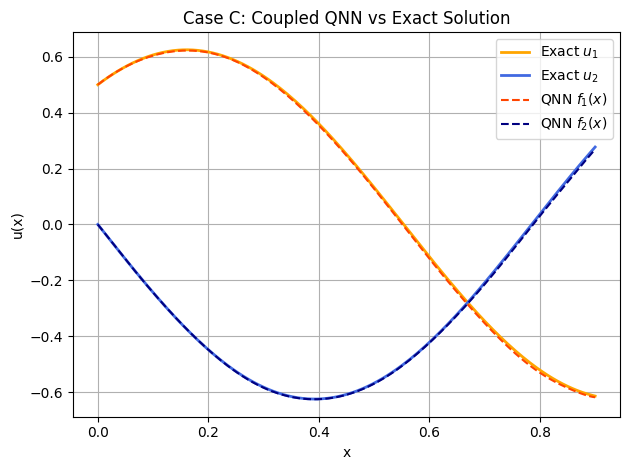

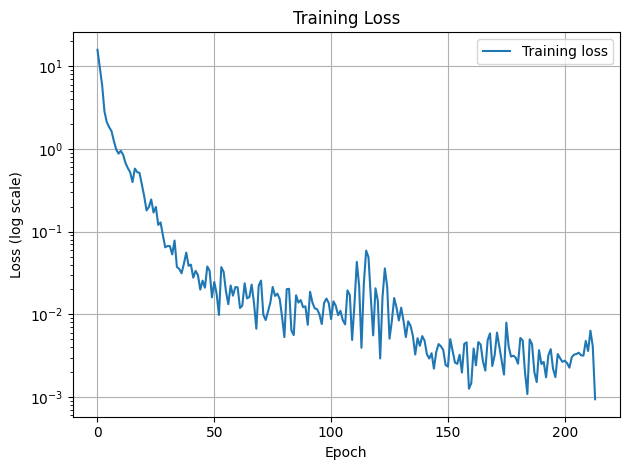

In [268]:
# Parameters from the paper
n_qubits = 6
depth = 5
encoding = "cheb_tower"
lambda1, lambda2 = 5.0, 3.0
u1_0, u2_0 = 0.5, 0.0

# Build two models
fmap = make_feature_map(n_qubits=n_qubits, encoding=encoding)
ansatz1 = make_ansatz(n_qubits=n_qubits, depth=depth)
ansatz2 = make_ansatz(n_qubits=n_qubits, depth=depth)
observable = make_observable(n_qubits=n_qubits)

model1, _ = make_model(fmap, ansatz1, observable, n_qubits)
model2, _ = make_model(fmap, ansatz2, observable, n_qubits)

# Loss
loss_fn = make_loss_fn_case_c_floating(lambda1, lambda2, u1_0, u2_0)

model1, model2, history = train_and_log_dual(
    model1, model2,
    loss_fn,
    n_epochs=250,
    n_points=100,
    xmin=0.0,
    xmax=0.9,
    lr=0.01,
    stop_threshold=1e-3,
    plateau_patience=25,
    min_lr=1e-9,
    clip_th=0.25,
    scheduler_eps=1e-9
)

# Plot results
plot_case_c_with_exact(model1, model2, lambda1, lambda2, u1_0, u2_0)
plot_loss_curve(history)

case_c_qnn_model1 = model1
case_c_qnn_model2 = model2
case_c_history = history


### Replicate results from the paper (D. Fluid dynamics applications)

In [262]:
def make_loss_fn_ns_steady():
    gamma = 1.4
    def loss_fn(model_rho, model_T, model_V, x):
        # Initial shifts at x = 0
        x0 = torch.tensor([[0.0]], requires_grad=True)
        shift_rho = 1.0 - model_rho(x0)
        shift_T = 1.0 - model_T(x0)
        shift_V = 0.1 - model_V(x0)

        # Apply shift to predictions
        rho = model_rho(x) + shift_rho
        T = model_T(x) + shift_T
        V = model_V(x) + shift_V

        # Compute gradients
        drho_dx = torch.autograd.grad(rho, x, grad_outputs=torch.ones_like(rho), create_graph=True)[0]
        dT_dx = torch.autograd.grad(T, x, grad_outputs=torch.ones_like(T), create_graph=True)[0]
        dV_dx = torch.autograd.grad(V, x, grad_outputs=torch.ones_like(V), create_graph=True)[0]

        A = 1 + 4.95 * (2*x - 1)**2
        dlnA_dx = (39.6*x - 19.8)/(4.95*(2*x - 1)**2 + 1)
        

        denom = T - V**2 + 1e-8  # add epsilon for stability

        res1 = drho_dx - (rho * V**2 / denom) * dlnA_dx
        res2 = dT_dx - (T * V**2 * (gamma - 1) / denom) * dlnA_dx
        res3 = dV_dx + (T * V / denom) * dlnA_dx

        return torch.mean(res1**2 + res2**2 + res3**2)
    return loss_fn


def f_exact_ns(x_tensor):
    x_eval = x_tensor.detach().cpu().numpy().flatten()

    def rhs(x, u):
        rho, T, V = u
        A = 1 + 4.95 * (x - 1)**2
        dlnA_dx = 4.95 * 2 * (x - 1) / A
        drho_dx = rho * dlnA_dx / (1 - V**2)
        dT_dx = T * V**2 * dlnA_dx / ((T - 1) * (1 - V**2))
        dV_dx = -V * dlnA_dx * (T + rho) / (rho * (1 - V**2))
        return [drho_dx, dT_dx, dV_dx]

    sol = solve_ivp(rhs, [x_eval[0], x_eval[-1]], [1.0, 1.0, 0.1], t_eval=x_eval, method="RK45")

    if not sol.success:
        raise RuntimeError("ODE solver failed to converge")

    return (
        torch.tensor(sol.y[0], dtype=torch.float32),
        torch.tensor(sol.y[1], dtype=torch.float32),
        torch.tensor(sol.y[2], dtype=torch.float32),
    )


In [263]:
def make_regularized_ns_loss(base_loss_fn, x_reg, targets_reg, n_iter, schedule="sigmoid", ndrop=0.3, delta=0.05):
    def zeta(epoch):
        if schedule == "linear":
            return 1.0 - epoch / n_iter
        elif schedule == "sigmoid":
            return 1.0 - np.tanh((epoch - ndrop * n_iter) / (delta * n_iter))
        else:
            raise ValueError(f"Unsupported schedule: {schedule}")

    def loss_fn(model_rho, model_T, model_V, x, epoch):
        base_loss = base_loss_fn(model_rho, model_T, model_V, x)
        rho_reg, T_reg, V_reg = targets_reg
        rho_pred = model_rho(x_reg)
        T_pred = model_T(x_reg)
        V_pred = model_V(x_reg)
        reg_loss = (
                torch.mean((rho_pred - rho_reg)**2) +
                torch.mean((T_pred - T_reg)**2) +
                torch.mean((V_pred - V_reg)**2)
        )
        return base_loss + zeta(epoch) * reg_loss
    return loss_fn


In [264]:
def plot_ns_solution(model_rho, model_T, model_V):
    x_plot = torch.linspace(0.0, 0.9, 200).unsqueeze(1)
    with torch.no_grad():
        rho_pred = model_rho(x_plot).flatten()
        T_pred = model_T(x_plot).flatten()
        V_pred = model_V(x_plot).flatten()

    #print("rho_pred", rho_pred)
    #print("T_pred", T_pred)
    #print("V_pred", V_pred)

    rho_exact, T_exact, V_exact = f_exact_ns(x_plot)

    plt.figure()
    plt.plot(x_plot, rho_exact, label="Exact ρ", color="green")
    plt.plot(x_plot, T_exact, label="Exact T", color="tomato")
    plt.plot(x_plot, V_exact, label="Exact V", color="blue")

    plt.plot(x_plot, rho_pred, "--", label="QNN ρ", color="darkgreen")
    plt.plot(x_plot, T_pred, "--", label="QNN T", color="firebrick")
    plt.plot(x_plot, V_pred, "--", label="QNN V", color="navy")

    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.title("Navier–Stokes: QNN vs Exact")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_ns_qnn_only(model_rho, model_T, model_V):
    x_plot = torch.linspace(0.0, 0.9, 200).unsqueeze(1)
    x0 = torch.tensor([[0.0]])

    with torch.no_grad():
        # Compute floating boundary shifts
        rho_shift = 1.0 - model_rho(x0)
        T_shift = 1.0 - model_T(x0)
        V_shift = 0.1 - model_V(x0)

        # Apply shift to full domain predictions
        rho_pred = (model_rho(x_plot) + rho_shift).flatten().detach().numpy()
        T_pred = (model_T(x_plot) + T_shift).flatten().detach().numpy()
        V_pred = (model_V(x_plot) + V_shift).flatten().detach().numpy()

    x_np = x_plot.detach().numpy().flatten()

    plt.figure()
    plt.plot(x_np, rho_pred, label="QNN ρ", color="royalblue", linestyle="-")
    plt.plot(x_np, T_pred, label="QNN T", color="tomato", linestyle="-")
    plt.plot(x_np, V_pred, label="QNN V", color="green", linestyle="-")

    plt.xlabel("x")
    plt.ylabel("Value")
    plt.title("QNN Predictions (Navier–Stokes)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [265]:
def make_stage2_grid(n_points=40):
    x_left = torch.linspace(0.0, 0.4, n_points // 2).unsqueeze(1)
    x_right = torch.linspace(0.6, 0.9, n_points // 2).unsqueeze(1)
    x = torch.cat([x_left, x_right], dim=0).requires_grad_()
    return x


In [266]:
def train_ns_models(
        model_rho, model_T, model_V,
        loss_fn,
        n_epochs=600,
        n_points=40,
        xmin=0.0,
        xmax=0.9,
        lr=0.005,
        stop_threshold=1e-4,
        plateau_patience=25,
        min_lr=1e-8,
        clip_th=0.25,
        scheduler_eps=1e-9,
        regularized=False
):
    all_params = list(model_rho.parameters()) + list(model_T.parameters()) + list(model_V.parameters())
    optimizer = torch.optim.Adam(all_params, lr=lr, eps=scheduler_eps)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=plateau_patience)

    losses = []
    theta_log = []
    progress = trange(n_epochs, desc="Training (NS)", dynamic_ncols=True)

    for epoch in progress:
        optimizer.zero_grad()
        x_train = make_training_grid(n_points, xmin, xmax, requires_grad=True) # For stage 1
        #x_train = make_stage2_grid(n_points) # For stage 2

        if regularized:
            loss = loss_fn(model_rho, model_T, model_V, x_train, epoch)
        else:
            loss = loss_fn(model_rho, model_T, model_V, x_train)

        loss.backward()

        # Clip all models
        torch.nn.utils.clip_grad_norm_(all_params, max_norm=clip_th)
        optimizer.step()

        loss_val = loss.item()
        losses.append(loss_val)
        theta_log.append([p.detach().cpu().numpy().copy() for p in model.parameters()])
        scheduler.step(loss_val)
        lr_now = optimizer.param_groups[0]['lr']
        progress.set_postfix(loss=loss_val, lr=lr_now)

        if loss_val < stop_threshold:
            break
        if lr_now < min_lr:
            break

    return model_rho, model_T, model_V, {"losses": losses}, {"thetas": theta_log}


Training (NS): 100%|██████████| 250/250 [02:26<00:00,  1.71it/s, loss=0.0113, lr=9.77e-7]  


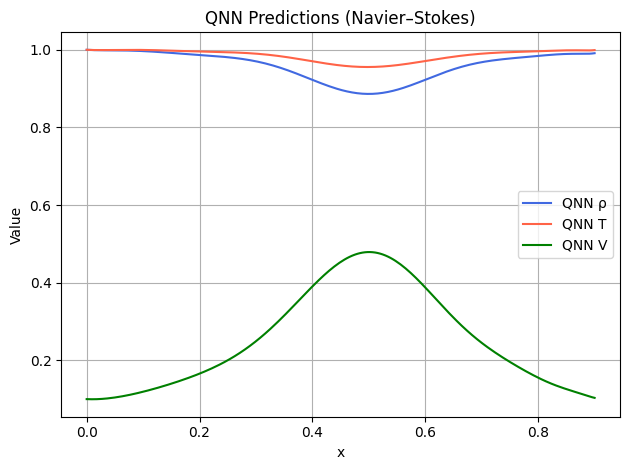

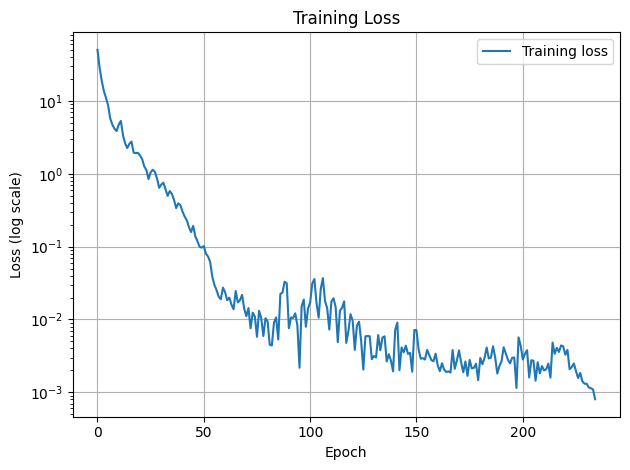

In [267]:

n_qubits = 6
depth = 16
encoding = "cheb_tower"

# Shared feature map and observable
fmap = make_feature_map(n_qubits=n_qubits, encoding=encoding)
observable = make_observable(n_qubits=n_qubits)

# Independent ansatz for each model
ansatz_rho = make_ansatz(n_qubits=n_qubits, depth=depth)
ansatz_T   = make_ansatz(n_qubits=n_qubits, depth=depth)
ansatz_V   = make_ansatz(n_qubits=n_qubits, depth=depth)

# Independent models
model_rho, _ = make_model(fmap, ansatz_rho, observable, n_qubits)
model_T,   _ = make_model(fmap, ansatz_T,   observable, n_qubits)
model_V,   _ = make_model(fmap, ansatz_V,   observable, n_qubits)

# Loss function for steady-state Navier–Stokes no regularization
loss_fn = make_loss_fn_ns_steady()

# Train the models
trained_model_rho, trained_model_T, trained_model_V, history_loss, history_theta = train_ns_models(
    model_rho, model_T, model_V,
    loss_fn,
    n_epochs=250,
    n_points=40,  # 20 from [0, 0.4] + 20 from [0.6, 0.9]
    xmin=0.0,
    xmax=0.9,  # still required but unused with custom grid
    lr=0.001,
    stop_threshold=1e-5,
    plateau_patience=15,
    min_lr=1e-9,
    clip_th=0.25,
    scheduler_eps=1e-9
)

# Plot the results
plot_ns_qnn_only(trained_model_rho, trained_model_T, trained_model_V)
plot_loss_curve(history)

case_d_qnn_model_rho = trained_model_rho
case_d_qnn_model_T = trained_model_T
case_d_qnn_model_V = trained_model_V
case_d_history_loss = history_loss
case_d_history_theta = history_theta

Classical Numerical Methods

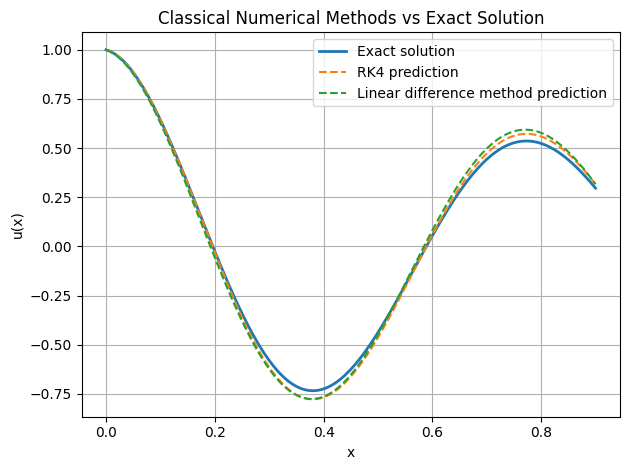

In [ ]:
#experiment A
# Define the differential equation
def f(x, u, lambda_, kappa):
    return -lambda_ * u * (kappa + np.tan(lambda_ * x))

# Exact analytical solution for the given case
def f_exact_case_a(x_tensor, lambda_=8.0, kappa=0.1):
    return torch.exp(-kappa * lambda_ * x_tensor) * torch.cos(lambda_ * x_tensor)

# Runge-Kutta 4th order method for solving ODE
def rk4(lambda_=8.0, kappa=0.1, u0=1.0, x0=0.0, x_end=0.9, num_points=200):
    x_vals = torch.linspace(x0, x_end, num_points) # Generate grid points
    h = x_vals[1] - x_vals[0] # Step size
    u_vals = torch.zeros_like(x_vals)
    u_vals[0] = u0 # Initial condition

    # Iterate using RK4 scheme
    for i in range(1, num_points):
        x_n = x_vals[i-1]
        u_n = u_vals[i-1]

        k1 = h * f(x_n, u_n, lambda_, kappa)
        k2 = h * f(x_n + h/2, u_n + k1/2, lambda_, kappa)
        k3 = h * f(x_n + h/2, u_n + k2/2, lambda_, kappa)
        k4 = h * f(x_n + h, u_n + k3, lambda_, kappa)

        u_vals[i] = u_n + (k1 + 2*k2 + 2*k3 + k4) / 6 # Update solution

    return x_vals, u_vals

# Simple finite difference method (Euler forward)
def finite_difference_method(lambda_=8.0, kappa=0.1, u0=1.0, x0=0.0, x_end=0.9, num_points=200):
    x_vals = torch.linspace(x0, x_end, num_points)
    h = x_vals[1] - x_vals[0]
    u_vals = torch.zeros_like(x_vals)
    u_vals[0] = u0 # Initial condition

    # Iterate using forward Euler method
    for i in range(1, num_points):
        x_n = x_vals[i-1]
        u_n = u_vals[i-1]
        u_vals[i] = h*f(x_n + h, u_n, lambda_, kappa) + u_n # Euler step

    return x_vals, u_vals

# Plot results comparing exact vs numerical method
def plot_case_a_with_rk4(lambda_=8.0, kappa=0.1):
    x_rk4, u_rk4 = rk4(lambda_, kappa)
    x_fd, u_fd = finite_difference_method(lambda_, kappa) 
    y_exact = f_exact_case_a(x_rk4, lambda_, kappa).flatten()

    plt.figure()
    plt.plot(x_rk4.numpy(), y_exact.numpy(), label="Exact solution", linewidth=2)
    plt.plot(x_rk4.numpy(), u_rk4.numpy(), "--", label="RK4 prediction")
    plt.plot(x_fd.numpy(), u_fd.numpy(), "--", label="Linear difference method prediction")
    plt.xlabel("x")
    plt.ylabel("u(x)")
    plt.title("Classical Numerical Methods vs Exact Solution")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_case_a_with_rk4(lambda_=8.0, kappa=0.1)


Training:   0%|          | 0/530 [00:00<?, ?it/s, loss=tensor([[6.4622]], dtype=torch.float32, grad_fn=<AddBackward0>), lr=0.005]   

Epoch 0, Loss: 213.326569


Training:   0%|          | 0/530 [00:00<?, ?it/s, loss=tensor([[0.9968]], dtype=torch.float32, grad_fn=<AddBackward0>), lr=0.00125]

Epoch 100, Loss: 1.428279


Training:   0%|          | 0/530 [00:00<?, ?it/s, loss=tensor([[0.9825]], dtype=torch.float32, grad_fn=<AddBackward0>), lr=0.00125]

Epoch 200, Loss: 0.995673


Training:   0%|          | 0/530 [00:00<?, ?it/s, loss=tensor([[0.8039]], dtype=torch.float32, grad_fn=<AddBackward0>), lr=0.00125]

Epoch 300, Loss: 1.030707


Training:   0%|          | 0/530 [00:01<?, ?it/s, loss=tensor([[0.6557]], dtype=torch.float32, grad_fn=<AddBackward0>), lr=0.00125]

Epoch 400, Loss: 0.830331


Training:   0%|          | 0/530 [00:01<?, ?it/s, loss=tensor([[0.6229]], dtype=torch.float32, grad_fn=<AddBackward0>), lr=0.00125]


Epoch 500, Loss: 0.630887


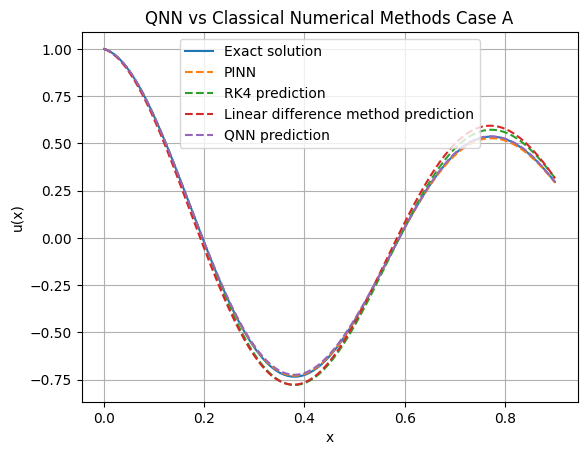

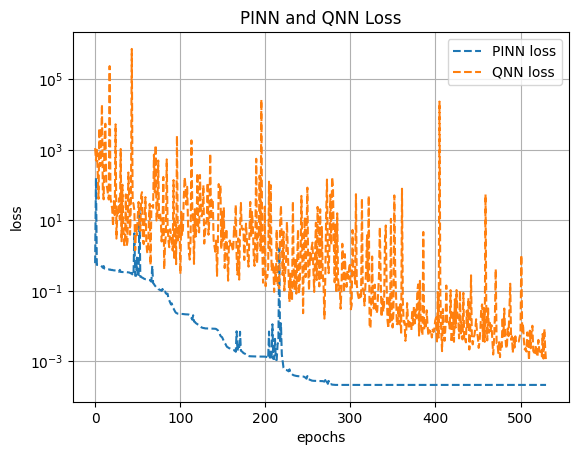

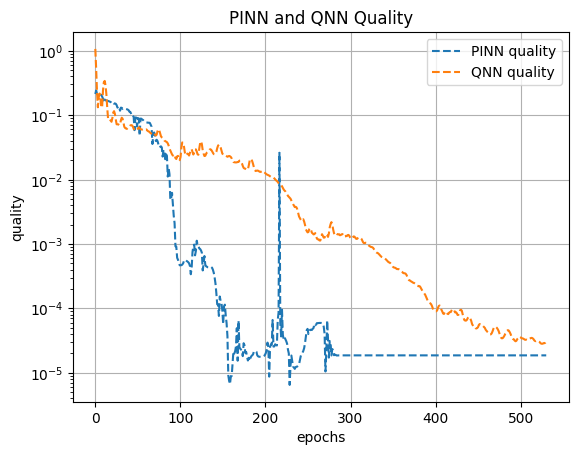

In [286]:
# Custom sine activation function for use in the PINN
class Sin(nn.Module):
    def forward(self, x):
        return torch.sin(x)

# Define the PINN model using sine activations
def make_pinn_model():
    return nn.Sequential(
        nn.Linear(1, 128),
        Sin(),
        nn.Linear(128, 128),
        Sin(),
        nn.Linear(128, 128),
        Sin(),
        nn.Linear(128, 1)
    ).float()

# Create the loss function for the PINN
def make_pinn_loss(lambda_=8.0, kappa=0.1):
    def loss_fn(model, x):
        # Normalize input and enable gradient tracking
        x = x.clone().detach().requires_grad_(True).float()
        u = model(x)

        # Compute du/dx via autograd
        du_dx = torch.autograd.grad(
            outputs=u,
            inputs=x,
            grad_outputs=torch.ones_like(u),
            create_graph=True
        )[0]

        # Define the residual of the PDE
        residual = du_dx + lambda_ * (kappa + torch.tan(lambda_ * x)) * u

        # Enforce initial condition u(0) = 1
        x0 = torch.tensor([[0.0]], dtype=torch.float32)
        x0 = x0.requires_grad_(True)
        u0 = model(x0)
        ic_loss = (u0 - 1.0) ** 2

        # Total loss = PDE residual + initial condition penalty
        return torch.mean(residual**2) + ic_loss
    return loss_fn

# Train the PINN using Adam optimizer
def train(model, loss_fn, epochs=1500, lr=0.01):
    plateau_patience=25
    scheduler_eps=1e-10
    clip_th=0.25
    stop_threshold=1e-3
    min_lr=1e-9
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=plateau_patience, factor=0.5, eps=scheduler_eps
    )
    x_train = torch.linspace(0.0, 0.9, 100, dtype=torch.float32).unsqueeze(1)
    losses = []
    theta  = []

    progress = trange(epochs, desc="Training", dynamic_ncols=True)

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, x_train)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_th)
        optimizer.step()
        loss_val = loss.item()
        scheduler.step(loss_val)
        current_lr = optimizer.param_groups[0]['lr']
        losses.append(loss_val)
        theta.append([p.detach().cpu().numpy().copy() for p in model.parameters()])
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
        progress.set_postfix(loss=loss, lr=current_lr)

    return theta, losses, x_train

def fine_tune_lbfgs2(model, loss_fn, x_train, epochs):
    optimizer = torch.optim.LBFGS(model.parameters(), max_iter=1, tolerance_grad=1e-9)
    losses = []
    thetas = []

    x_train = x_train.clone().detach().requires_grad_(True).float()

    for _ in range(epochs):
        def closure():
            optimizer.zero_grad()
            loss = loss_fn(model, x_train)
            loss.backward()
            loss_val = loss.item()
            current_theta = [p.detach().cpu().numpy().copy() for p in model.parameters()]
            losses.append(loss_val)
            thetas.append(current_theta)
            return loss

        optimizer.step(closure)

    return thetas, losses

def fine_tune_lbfgs(model, loss_fn, x_train, epochs):
    optimizer = torch.optim.LBFGS(model.parameters(), max_iter=epochs, tolerance_grad=1e-9)

    def closure():
        optimizer.zero_grad()
        loss = loss_fn(model, x_train)
        loss.backward()
        return loss
    
    optimizer.step(closure)
    
# Plot PINN and classical methods vs exact solution
def plot_solution(model, qnn_model, lambda_=8.0, kappa=0.1):
    x_test = torch.linspace(0.0, 0.9, 200, dtype=torch.float32).unsqueeze(1)
    with torch.no_grad():
        u_pred = model(x_test).flatten()
    u_exact = f_exact_case_a(x_test, lambda_, kappa).flatten()

    x_rk4, u_rk4 = rk4(lambda_, kappa)
    x_fd, u_fd = finite_difference_method(lambda_, kappa)

    with torch.no_grad():
        y_model_qnn = qnn_model(x_test).flatten()
        x0_qnn = torch.tensor([[0.0]],dtype=torch.float32)
        shift = 1.0 - qnn_model(x0_qnn).item()
        y_model_shifted = y_model_qnn + shift

    plt.plot(x_rk4.numpy(), u_exact.numpy(), label="Exact solution")
    plt.plot(x_test.numpy().flatten(), u_pred.numpy(), '--', label="PINN")
    plt.plot(x_rk4.numpy(), u_rk4.numpy(), "--", label="RK4 prediction")
    plt.plot(x_fd.numpy(), u_fd.numpy(), "--", label="Linear difference method prediction")
    plt.plot(x_test.numpy().flatten(), y_model_shifted.numpy(), "--", label="QNN prediction")
    plt.xlabel("x")
    plt.ylabel("u(x)")
    plt.legend()
    plt.grid(True)
    plt.title("QNN vs Classical Numerical Methods Case A")
    plt.show()

# Plot training loss over epochs
def plot_pinn_loss(losses, qnn_history, num_epochs):
    x_test = torch.linspace(0.0, num_epochs, num_epochs, dtype=torch.float32).unsqueeze(1)
    
    plt.semilogy(x_test.numpy().flatten(), losses, "--", label="PINN loss")
    plt.semilogy(x_test.numpy().flatten(), qnn_history, "--", label="QNN loss")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()
    plt.grid(True)
    plt.title("PINN and QNN Loss")
    plt.show()

def plot_pinn_quality(theta, qnn_history, num_epochs):
    x_test = torch.linspace(0.0, num_epochs, num_epochs, dtype=torch.float32).unsqueeze(1)

    plt.semilogy(x_test.numpy().flatten(), theta, "--", label="PINN quality")
    plt.semilogy(x_test.numpy().flatten(), qnn_history, "--", label="QNN quality")
    plt.xlabel("epochs")
    plt.ylabel("quality")
    plt.legend()
    plt.grid(True)
    plt.title("PINN and QNN Quality")
    plt.show()

def compute_pinn_solution_quality(theta, x_test, lambda_=8.0, kappa=0.1):
    quality = []
    for params in theta:
        # Recreate a fresh model with same architecture
        model = make_pinn_model()
        
        # Load parameters
        with torch.no_grad():
            for p, p_val in zip(model.parameters(), params):
                p.copy_(torch.tensor(p_val))

        # Get prediction
        with torch.no_grad():
            u_pred = model(x_test).flatten()

        # Get exact solution
        u_exact = f_exact_case_a(x_test, lambda_, kappa).flatten()

        # Compute MSE (or L2 error) as quality
        error = torch.mean((u_pred - u_exact)**2).item()
        quality.append(error)

    return quality

def compute_qnn_solution_quality(theta_log, fmap, ansatz, observable, n_qubits, x_test, lambda_=8.0, kappa=0.1):
    quality = []

    # Build empty QNN structure to load weights into each epoch
    base_model, _ = make_model(fmap, ansatz, observable, n_qubits)

    for theta in theta_log:
        # Reset model with copied weights
        with torch.no_grad():
            for p, p_val in zip(base_model.parameters(), theta):
                p.copy_(torch.tensor(p_val))

        # Predict
        with torch.no_grad():
            u_pred = base_model(x_test).flatten()

        # Apply shift for boundary condition (u(0) = 1)
        x0 = torch.tensor([[0.0]], dtype=torch.float32)
        shift = 1.0 - base_model(x0).item()
        u_pred_shifted = u_pred + shift

        # Ground truth
        u_exact = f_exact_case_a(x_test, lambda_, kappa).flatten()

        # Quality (MSE)
        error = torch.mean((u_pred_shifted - u_exact)**2).item()
        quality.append(error)

    return quality


# Train and plot results
model = make_pinn_model()
loss_fn = make_pinn_loss(lambda_=8.0, kappa=0.1)
theta, history, x_train = train(model, loss_fn, epochs=530)
theta , loss = fine_tune_lbfgs2(model, loss_fn, x_train, epochs = 530)
fine_tune_lbfgs(model, loss_fn, x_train, epochs = 530)

plot_solution(model, case_a_qnn_model)

qnn_history_loss = case_a_history["losses"]
plot_pinn_loss(loss, qnn_history_loss, 530)

theta_qnn = case_a_history["thetas"]  # from your QNN
x_test = torch.linspace(0.0, 0.9, 200, dtype=torch.float32).unsqueeze(1)

# Create circuits again with same settings used in training
fmap = make_feature_map(n_qubits=6)
ansatz = make_ansatz(n_qubits=6, depth=16)
observable = make_observable(n_qubits=6)
# Compute quality
qnn_t = compute_qnn_solution_quality(theta_qnn, fmap, ansatz, observable, 6, x_test)

t = compute_pinn_solution_quality(theta, x_test)

plot_pinn_quality(t, qnn_t, 530)


Training:   0%|          | 0/1500 [00:00<?, ?it/s, loss=tensor([[70.5468]], dtype=torch.float32, grad_fn=<AddBackward0>), lr=0.0025]  

Epoch 0, Loss: 3031.984619


Training:   0%|          | 0/1500 [00:00<?, ?it/s, loss=tensor([[1.6648]], dtype=torch.float32, grad_fn=<AddBackward0>), lr=0.000625]

Epoch 100, Loss: 6.314466


Training:   0%|          | 0/1500 [00:00<?, ?it/s, loss=tensor([[0.9884]], dtype=torch.float32, grad_fn=<AddBackward0>), lr=7.81e-5] 

Epoch 200, Loss: 1.249241


Training:   0%|          | 0/1500 [00:00<?, ?it/s, loss=tensor([[0.9819]], dtype=torch.float32, grad_fn=<AddBackward0>), lr=3.91e-5]

Epoch 300, Loss: 0.986742


Training:   0%|          | 0/1500 [00:01<?, ?it/s, loss=tensor([[0.9702]], dtype=torch.float32, grad_fn=<AddBackward0>), lr=3.91e-5]

Epoch 400, Loss: 0.985711


Training:   0%|          | 0/1500 [00:01<?, ?it/s, loss=tensor([[0.9569]], dtype=torch.float32, grad_fn=<AddBackward0>), lr=3.91e-5]

Epoch 500, Loss: 0.968897


Training:   0%|          | 0/1500 [00:01<?, ?it/s, loss=tensor([[0.9423]], dtype=torch.float32, grad_fn=<AddBackward0>), lr=3.91e-5]

Epoch 600, Loss: 0.954522


Training:   0%|          | 0/1500 [00:01<?, ?it/s, loss=tensor([[0.9287]], dtype=torch.float32, grad_fn=<AddBackward0>), lr=3.91e-5]

Epoch 700, Loss: 0.940896


Training:   0%|          | 0/1500 [00:01<?, ?it/s, loss=tensor([[0.9118]], dtype=torch.float32, grad_fn=<AddBackward0>), lr=3.91e-5]

Epoch 800, Loss: 0.926309


Training:   0%|          | 0/1500 [00:02<?, ?it/s, loss=tensor([[0.8994]], dtype=torch.float32, grad_fn=<AddBackward0>), lr=3.91e-5]

Epoch 900, Loss: 0.911500


Training:   0%|          | 0/1500 [00:02<?, ?it/s, loss=tensor([[0.8919]], dtype=torch.float32, grad_fn=<AddBackward0>), lr=3.91e-5]

Epoch 1000, Loss: 0.896228


Training:   0%|          | 0/1500 [00:02<?, ?it/s, loss=tensor([[0.8751]], dtype=torch.float32, grad_fn=<AddBackward0>), lr=1.95e-5]

Epoch 1100, Loss: 0.889237


Training:   0%|          | 0/1500 [00:02<?, ?it/s, loss=tensor([[0.8632]], dtype=torch.float32, grad_fn=<AddBackward0>), lr=1.95e-5]

Epoch 1200, Loss: 0.874120


Training:   0%|          | 0/1500 [00:03<?, ?it/s, loss=tensor([[0.8518]], dtype=torch.float32, grad_fn=<AddBackward0>), lr=1.95e-5]

Epoch 1300, Loss: 0.863269


Training:   0%|          | 0/1500 [00:03<?, ?it/s, loss=tensor([[0.8463]], dtype=torch.float32, grad_fn=<AddBackward0>), lr=1.95e-5]

Epoch 1400, Loss: 0.850675


Training:   0%|          | 0/1500 [00:03<?, ?it/s, loss=tensor([[0.8454]], dtype=torch.float32, grad_fn=<AddBackward0>), lr=1.95e-5]


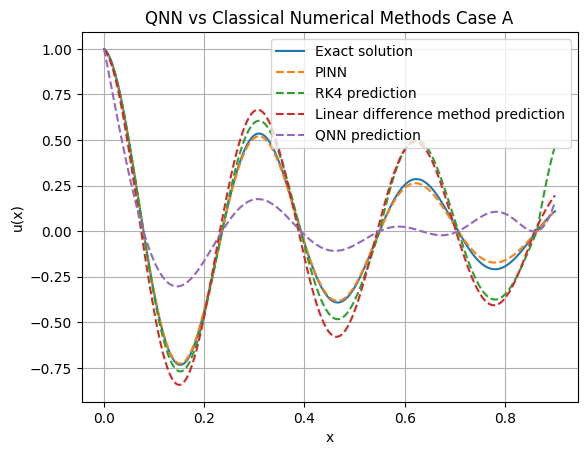

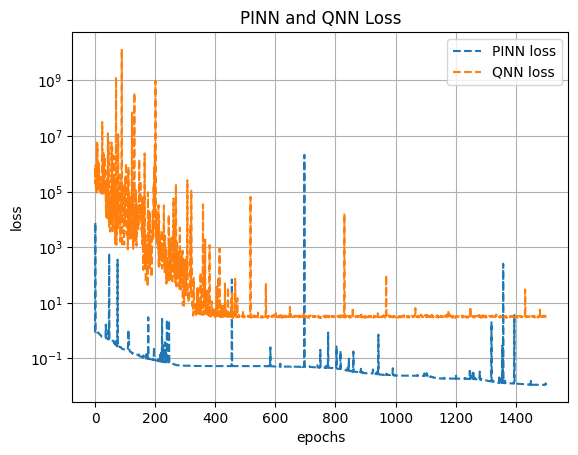

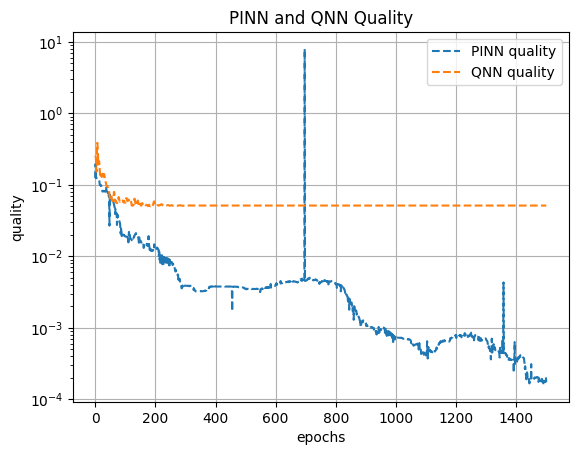

In [ ]:
#experiment A lambda = 20
def train2(model, loss_fn, epochs=1500, lr=0.01):
    plateau_patience=25
    scheduler_eps=1e-10
    clip_th=0.25
    stop_threshold=1e-3
    min_lr=1e-9
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=plateau_patience, factor=0.5, eps=scheduler_eps
    )
    x_train = torch.linspace(0.0, 0.9, 100, dtype=torch.float32).unsqueeze(1)
    losses = []
    theta  = []

    progress = trange(epochs, desc="Training", dynamic_ncols=True)

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, x_train)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_th)
        optimizer.step()
        loss_val = loss.item()
        scheduler.step(loss_val)
        current_lr = optimizer.param_groups[0]['lr']
        losses.append(loss_val)
        theta.append([p.detach().cpu().numpy().copy() for p in model.parameters()])
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
        progress.set_postfix(loss=loss, lr=current_lr)

    return theta, losses, x_train

# Train and plot results for lambda = 20.0
model = make_pinn_model()
loss_fn = make_pinn_loss(lambda_= 20.0)
theta, history, x_train = train2(model, loss_fn)
theta , loss = fine_tune_lbfgs2(model, loss_fn, x_train, epochs = 1500)
fine_tune_lbfgs(model, loss_fn, x_train, epochs = 1500)
plot_solution(model,case_b_qnn_model_lambda20, lambda_ = 20.0)

qnn_history_loss = case_a_20_history["losses"]
plot_pinn_loss(loss, qnn_history_loss, 1500)

theta_qnn = case_a_20_history["thetas"]  # from your QNN
x_test = torch.linspace(0.0, 0.9, 200, dtype=torch.float32).unsqueeze(1)

fmap = make_feature_map(n_qubits=6)
ansatz = make_ansatz(n_qubits=6, depth=16)
observable = make_observable(n_qubits=6)
# Compute quality
qnn_t = compute_qnn_solution_quality(theta_qnn, fmap, ansatz, observable, 6, x_test, lambda_= 20.0)

t = compute_pinn_solution_quality(theta, x_test, lambda_= 20.0)

plot_pinn_quality(t, qnn_t, 1500)


Training:   0%|          | 0/500 [00:00<?, ?it/s, loss=tensor([[0.7162]], dtype=torch.float32, grad_fn=<AddBackward0>), lr=0.01]   

Epoch 0, Loss: 0.911232


Training:   0%|          | 0/500 [00:00<?, ?it/s, loss=tensor([[0.5725]], dtype=torch.float32, grad_fn=<AddBackward0>), lr=0.005]

Epoch 100, Loss: 0.711902


Training:   0%|          | 0/500 [00:00<?, ?it/s, loss=tensor([[0.3990]], dtype=torch.float32, grad_fn=<AddBackward0>), lr=0.005]

Epoch 200, Loss: 0.603678


Training:   0%|          | 0/500 [00:00<?, ?it/s, loss=tensor([[0.0676]], dtype=torch.float32, grad_fn=<AddBackward0>), lr=0.005]

Epoch 300, Loss: 0.403419


Training:   0%|          | 0/500 [00:01<?, ?it/s, loss=tensor([[0.0185]], dtype=torch.float32, grad_fn=<AddBackward0>), lr=0.0025]

Epoch 400, Loss: 0.078831


Training:   0%|          | 0/500 [00:01<?, ?it/s, loss=tensor([[0.0134]], dtype=torch.float32, grad_fn=<AddBackward0>), lr=0.0025]


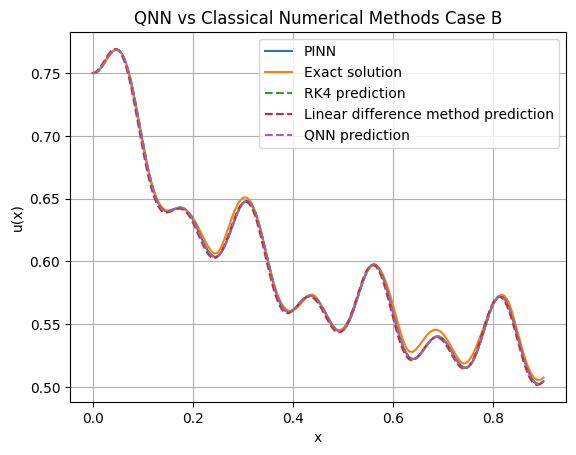

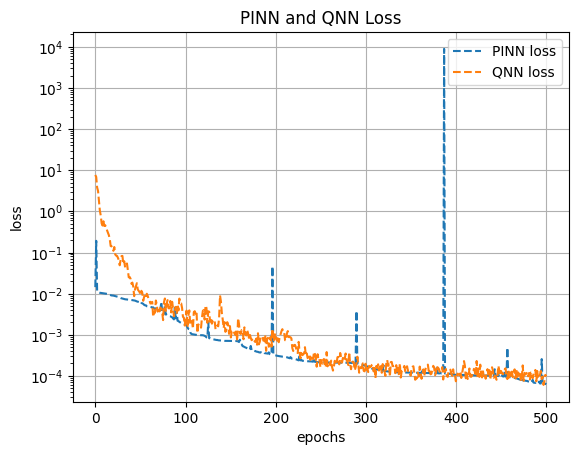

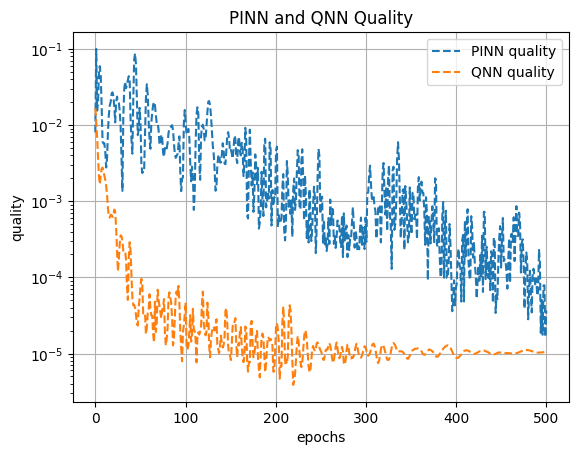

In [ ]:
#experiment B
def f_b(x, u):
    return 4 * u - 6 * u**2 + torch.sin(50 * x) + u * torch.cos(25 * x) - 0.5

# Classical RK4 method for solving the ODE in Case B
def rk4_b(u0=0.75, x0=0.0, x_end=0.9, num_points=200):
    x_vals = torch.linspace(x0, x_end, num_points)
    h = x_vals[1] - x_vals[0]
    u_vals = torch.zeros_like(x_vals)
    u_vals[0] = u0 # initial condition

    for i in range(1, num_points):
        x_n = x_vals[i-1]
        u_n = u_vals[i-1]

        # Compute RK4 stages
        k1 = h * f_b(x_n, u_n)
        k2 = h * f_b(x_n + h/2, u_n + k1/2)
        k3 = h * f_b(x_n + h/2, u_n + k2/2)
        k4 = h * f_b(x_n + h, u_n + k3)

        # Update solution
        u_vals[i] = u_n + (k1 + 2*k2 + 2*k3 + k4) / 6

    return x_vals, u_vals

# Simple explicit finite difference method for Case B
def finite_difference_method_b(u0=0.75, x0=0.0, x_end=0.9, num_points=200):
    x_vals = torch.linspace(x0, x_end, num_points)
    h = x_vals[1] - x_vals[0]
    u_vals = torch.zeros_like(x_vals)
    u_vals[0] = u0

    for i in range(1, num_points):
        x_n = x_vals[i-1]
        u_n = u_vals[i-1]
        u_vals[i] = h*f_b(x_n + h, u_n) + u_n # Euler-style update

    return x_vals, u_vals


# Define the PINN loss for Case B
def make_pinn_loss_b():
    def loss_fn(model, x):
        # Normalize input and enable gradient tracking
        x_norm = x.clone().detach().requires_grad_(True).float()
        u = model(x_norm)

        # Compute du/dx using autograd
        du_dx = torch.autograd.grad(
            outputs=u,
            inputs=x_norm,
            grad_outputs=torch.ones_like(u),
            create_graph=True
        )[0]
        # Define the residual for Case B
        residual = du_dx - 4 * u + 6 * u**2 - torch.sin(50 * x) - u * torch.cos(25 * x) + 0.5

        # Enforce initial condition: u(0) = 0.75
        x0 = torch.tensor([[0.0]], dtype=torch.float32)
        x0_norm = x0.requires_grad_(True)
        u0 = model(x0_norm)
        ic_loss = (u0 - 0.75) ** 2
        # Total loss = PDE residual + initial condition
        return torch.mean(residual**2) + ic_loss
    return loss_fn

# Plot predictions from PINN, QNN, and classical solvers for Case B
def plot_solution_b(model, qnn_model):
    x_test = torch.linspace(0.0, 0.9, 200, dtype=torch.float32).unsqueeze(1)
    with torch.no_grad():
        u_pred = model(x_test).flatten()

    u_exact = f_exact_case_b(x_test).flatten()

    x_rk4, u_rk4 = rk4_b()
    x_fd, u_fd = finite_difference_method_b()

    with torch.no_grad():
        y_model_qnn = qnn_model(x_test).flatten()
        x0_qnn = torch.tensor([[0.0]],dtype=torch.float32)
        shift = 0.75 - qnn_model(x0_qnn).item()
        y_model_shifted = y_model_qnn + shift

    plt.plot(x_test.numpy(), u_pred.numpy(), '-', label="PINN")
    plt.plot(x_rk4.numpy(), u_exact.numpy(), label="Exact solution")
    plt.plot(x_rk4.numpy(), u_rk4.numpy(), "--", label="RK4 prediction")
    plt.plot(x_fd.numpy(), u_fd.numpy(), "--", label="Linear difference method prediction")
    plt.plot(x_test.numpy().flatten(), y_model_shifted.numpy(), "--", label="QNN prediction")
    plt.xlabel("x")
    plt.ylabel("u(x)")
    plt.legend()
    plt.grid(True)
    plt.title("QNN vs Classical Numerical Methods Case B")
    plt.show()

def compute_pinn_solution_quality_b(theta, x_test):
    quality = []
    for params in theta:
        # Recreate a fresh model
        model = make_pinn_model()
        
        # Load weights
        with torch.no_grad():
            for p, p_val in zip(model.parameters(), params):
                p.copy_(torch.tensor(p_val))

        # Compute shift: u(0) should be 0.75
        x0 = torch.tensor([[0.0]], dtype=torch.float32)
        with torch.no_grad():
            u0 = model(x0)
            shift = 0.75 - u0.item()

        # Get prediction with shift applied
        with torch.no_grad():
            u_pred = model(x_test).flatten() + shift

        # Get exact solution
        u_exact = f_exact_case_b(x_test).flatten()

        # Compute MSE (L2 error)
        error = torch.mean((u_pred - u_exact)**2).item()
        quality.append(error)

    return quality

def compute_qnn_solution_quality_b(theta_log, fmap, ansatz, observable, n_qubits, x_test):
    quality = []

    # Prepare base model
    base_model, _ = make_model(fmap, ansatz, observable, n_qubits)

    for theta in theta_log:
        # Load parameters
        with torch.no_grad():
            for p, p_val in zip(base_model.parameters(), theta):
                p.copy_(torch.tensor(p_val))

        with torch.no_grad():
            # Raw prediction
            u_raw = base_model(x_test).flatten()

            # Compute shift using boundary point
            x0 = torch.tensor([[0.0]], dtype=torch.float32)
            u0 = base_model(x0)
            shift = 0.75 - u0.item()

            # Apply shift
            u_pred = u_raw + shift

        # Exact solution
        u_exact = f_exact_case_b(x_test).flatten()

        # Compute square error
        error = torch.mean((u_pred - u_exact)**2).item()
        quality.append(error)

    return quality


# Run training and evaluation for Case B
model = make_pinn_model()
loss_fn = make_pinn_loss_b()
theta, history, x_train = train(model, loss_fn, epochs=500)
theta2 , loss = fine_tune_lbfgs2(model, loss_fn, x_train, epochs = 500)
fine_tune_lbfgs(model, loss_fn, x_train, epochs = 500)
plot_solution_b(model, case_b_qnn_model)

qnn_history_loss = case_b_history["losses"]
plot_pinn_loss(loss, qnn_history_loss, 500)

theta_qnn = case_b_history["thetas"]  # from your QNN
x_test = torch.linspace(0.0, 0.9, 200, dtype=torch.float32).unsqueeze(1)

# Create circuits again with same settings used in training
fmap = make_feature_map(n_qubits=12)
ansatz = make_ansatz(n_qubits=12, depth=5)
observable = make_observable(n_qubits=12)
# Compute quality
qnn_t = compute_qnn_solution_quality_b(theta_qnn, fmap, ansatz, observable, 12, x_test)
t = compute_pinn_solution_quality_b(theta, x_test)
plot_pinn_quality(t, qnn_t, 500)

Training:   0%|          | 0/214 [00:00<?, ?it/s, loss=tensor(0.7984, dtype=torch.float32, grad_fn=<MeanBackward0>), lr=0.001]

Epoch 0, Loss: 7.234290


Training:   0%|          | 0/214 [00:00<?, ?it/s, loss=tensor(0.2273, dtype=torch.float32, grad_fn=<MeanBackward0>), lr=0.0005]

Epoch 100, Loss: 0.285161


Training:   0%|          | 0/214 [00:00<?, ?it/s, loss=tensor(0.1009, dtype=torch.float32, grad_fn=<MeanBackward0>), lr=0.0005]


Epoch 200, Loss: 0.110670


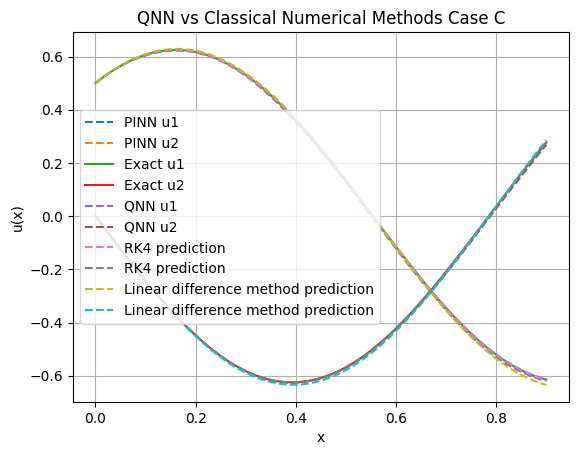

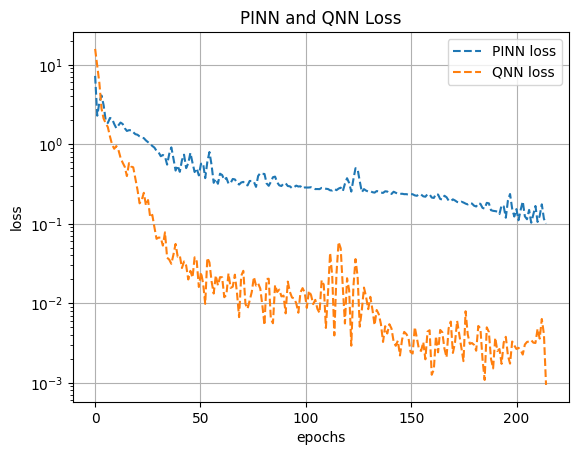

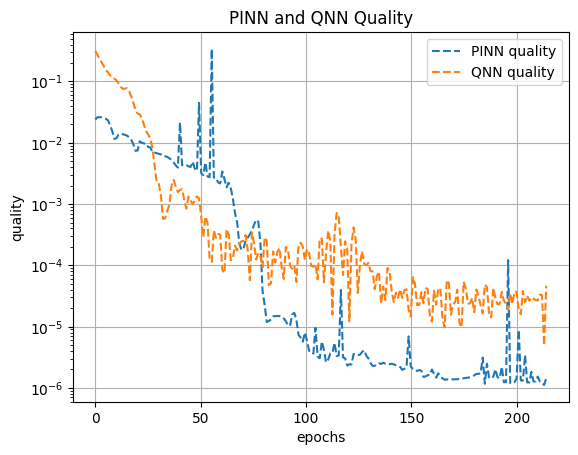

In [ ]:
#experiment C
def make_pinn_loss_c(model1, model2, lambda1=5.0, lambda2=3.0, u1_0=0.5, u2_0=0.0):
    def loss_fn(x):
        x = x.clone().detach().requires_grad_(True).float()
        # Predict u1 and u2 using separate models
        u1 = model1(x)
        u2 = model2(x)

        # Shift outputs to enforce initial conditions u1(0)=u1_0, u2(0)=u2_0
        shift1 = u1_0 - model1(torch.tensor([[0.0]], dtype=torch.float32))
        shift2 = u2_0 - model2(torch.tensor([[0.0]], dtype=torch.float32))
        u1 = u1 + shift1
        u2 = u2 + shift2

        # Derivatives du1/dx and du2/dx via autograd
        du1_dx = torch.autograd.grad(u1, x, grad_outputs=torch.ones_like(u1), create_graph=True)[0]
        du2_dx = torch.autograd.grad(u2, x, grad_outputs=torch.ones_like(u2), create_graph=True)[0]
        
        # Residuals based on the coupled ODE system
        res1 = du1_dx - lambda1 * u2 - lambda2 * u1
        res2 = du2_dx + lambda2 * u2 + lambda1 * u1

        return torch.mean(res1**2 + res2**2) # Minimize both residuals
    return loss_fn

# Train the PINN using Adam optimizer
def train_pinn_c(model1, model2, loss_fn, epochs=1500, lr=1e-3):
    plateau_patience=10
    scheduler_eps=1e-10
    clip_th=0.25
    stop_threshold=1e-5
    min_lr=1e-8
    optimizer = torch.optim.Adam(
        list(model1.parameters()) + list(model2.parameters()), lr=lr
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=plateau_patience, factor=0.5, eps=scheduler_eps
    )
    x_train = torch.linspace(0.0, 0.9, 100, dtype=torch.float32).unsqueeze(1)
    losses = []
    theta = []
    progress = trange(epochs, desc="Training", dynamic_ncols=True)
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(x_train)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
    list(model1.parameters()) + list(model2.parameters()), max_norm=clip_th
)
        optimizer.step()
        loss_val = loss.item()
        scheduler.step(loss_val)
        current_lr = optimizer.param_groups[0]['lr']
        losses.append(loss_val)
        theta.append(
    [p.detach().cpu().numpy().copy() for p in model1.parameters()] +
    [p.detach().cpu().numpy().copy() for p in model2.parameters()]
)
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
        progress.set_postfix(loss=loss, lr=current_lr)

        if loss_val < stop_threshold:
            print(f"\n Early stopping at epoch {epoch} — loss < {stop_threshold:.1e}")
            break

        # (2) learning rate too small
        if current_lr < min_lr:
            print(f"\n Stopping at epoch {epoch} — learning rate below {min_lr}")
            break

    return theta, losses, x_train

# Plot PINN and classical methods vs exact solution
def fine_tune_lbfgs_c(model1, model2, loss_fn, x_train, epochs):
    optimizer = torch.optim.LBFGS(
        list(model1.parameters()) + list(model2.parameters()), max_iter=1, tolerance_grad=1e-9
    )
    losses = []
    thetas = []

    x_train = x_train.clone().detach().requires_grad_(True).float()

    for _ in range(epochs):
        def closure():
            optimizer.zero_grad()
            loss = loss_fn(x_train)
            loss.backward()
            loss_val = loss.item()
            current_theta = ([p.detach().cpu().numpy().copy() for p in model1.parameters()] + [p.detach().cpu().numpy().copy() for p in model2.parameters()])
            losses.append(loss_val)
            thetas.append(current_theta)
            return loss

        optimizer.step(closure)

    return thetas, losses

def fine_tune_lbfgs_c2(model1, model2, loss_fn, x_train, epochs):
    optimizer = torch.optim.LBFGS(
        list(model1.parameters()) + list(model2.parameters()), max_iter=500, tolerance_grad=1e-9
    )
    x_train = x_train.clone().detach().requires_grad_(True).float()

    def closure():
        optimizer.zero_grad()
        loss = loss_fn(x_train)
        loss.backward()
        return loss
    
    optimizer.step(closure)


def f_case_c(x, u, lambda1=5.0, lambda2=3.0):
    u1, u2 = u[0], u[1]
    du1_dx = lambda1 * u2 + lambda2 * u1
    du2_dx = -lambda2 * u2 - lambda1 * u1
    return torch.tensor([du1_dx, du2_dx])

# Classical RK4 method for solving the ODE in Case C
def rk4_c(u0=torch.tensor([0.5, 0.0]), x0=0.0, x_end=0.9, num_points=200, lambda1=5.0, lambda2=3.0):
    x_vals = torch.linspace(x0, x_end, num_points)
    h = x_vals[1] - x_vals[0]
    u_vals = torch.zeros(num_points, 2)
    u_vals[0] = u0

    for i in range(1, num_points):
        x_n = x_vals[i - 1]
        u_n = u_vals[i - 1]

        k1 = h * f_case_c(x_n, u_n, lambda1, lambda2)
        k2 = h * f_case_c(x_n + h / 2, u_n + k1 / 2, lambda1, lambda2)
        k3 = h * f_case_c(x_n + h / 2, u_n + k2 / 2, lambda1, lambda2)
        k4 = h * f_case_c(x_n + h, u_n + k3, lambda1, lambda2)

        u_vals[i] = u_n + (k1 + 2 * k2 + 2 * k3 + k4) / 6

    return x_vals, u_vals[:, 0], u_vals[:, 1]

# Simple explicit finite difference method for Case C
def finite_difference_method_c(u0=torch.tensor([0.5, 0.0]), x0=0.0, x_end=0.9, num_points=200, lambda1=5.0, lambda2=3.0):
    x_vals = torch.linspace(x0, x_end, num_points)
    h = x_vals[1] - x_vals[0]
    u_vals = torch.zeros(num_points, 2)
    u_vals[0] = u0

    for i in range(1, num_points):
        x_n = x_vals[i - 1]
        u_n = u_vals[i - 1]
        du_dx = f_case_c(x_n, u_n, lambda1, lambda2)
        u_vals[i] = u_n + h * du_dx

    return x_vals, u_vals[:, 0], u_vals[:, 1]

# Plot predictions from PINN, QNN, and classical solvers for Case C
def plot_solution_c(model1, model2, qnn_model1, qnn_model2, lambda1=5.0, lambda2=3.0, u1_0=0.5, u2_0=0.0):
    x_test = torch.linspace(0.0, 0.9, 200, dtype=torch.float32).unsqueeze(1)

    with torch.no_grad():
        shift1 = u1_0 - model1(torch.tensor([[0.0]], dtype=torch.float32))
        shift2 = u2_0 - model2(torch.tensor([[0.0]], dtype=torch.float32))

        u1_pred = (model1(x_test) + shift1).flatten()
        u2_pred = (model2(x_test) + shift2).flatten()

    u1_exact, u2_exact = f_exact_case_c(x_test, lambda1, lambda2, u1_0, u2_0)

    with torch.no_grad():
        shift1_q = u1_0 - qnn_model1(torch.tensor([[0.0]], dtype=torch.float32))
        shift2_q = u2_0 - qnn_model2(torch.tensor([[0.0]], dtype=torch.float32))

        u1_pred_qnn = (qnn_model1(x_test) + shift1_q).flatten()
        u2_pred_qnn = (qnn_model2(x_test) + shift2_q).flatten()

    x_rk4, u1_rk4, u2_rk4 = rk4_c()
    x_fd, u1_fd, u2_fd = finite_difference_method_c()

    plt.plot(x_test.numpy(), u1_pred.numpy(), '--', label="PINN u1")
    plt.plot(x_test.numpy(), u2_pred.numpy(), '--', label="PINN u2")
    plt.plot(x_test.numpy(), u1_exact.numpy(), label="Exact u1")
    plt.plot(x_test.numpy(), u2_exact.numpy(), label="Exact u2")
    plt.plot(x_test.numpy(), u1_pred_qnn.numpy(), '--', label="QNN u1")
    plt.plot(x_test.numpy(), u2_pred_qnn.numpy(), '--', label="QNN u2")
    plt.plot(x_rk4.numpy(), u1_rk4.numpy(), "--", label="RK4 prediction")
    plt.plot(x_rk4.numpy(), u2_rk4.numpy(), "--", label="RK4 prediction")
    plt.plot(x_fd.numpy(), u1_fd.numpy(), "--", label="Linear difference method prediction")
    plt.plot(x_fd.numpy(), u2_fd.numpy(), "--", label="Linear difference method prediction")
    plt.xlabel("x")
    plt.ylabel("u(x)")
    plt.legend()
    plt.grid(True)
    plt.title("QNN vs Classical Numerical Methods Case C")
    plt.show()

def compute_pinn_solution_quality_c(theta_list, x_test, lambda1=5.0, lambda2=3.0, u1_0=0.5, u2_0=0.0):
    quality = []
    model1 = make_pinn_model()
    model2 = make_pinn_model()
    x_test = x_test.float()
    for t in theta_list:

        # Split params: assume same size
        t1, t2 = t[:len(t)//2], t[len(t)//2:]

        with torch.no_grad():
            for p, val in zip(model1.parameters(), t1):
                p.copy_(torch.tensor(val))
            for p, val in zip(model2.parameters(), t2):
                p.copy_(torch.tensor(val))

            u1 = model1(x_test).flatten().float()
            u2 = model2(x_test).flatten().float()

            shift1 = u1_0 - model1(torch.tensor([[0.0]], dtype=torch.float32)).item()
            shift2 = u2_0 - model2(torch.tensor([[0.0]], dtype=torch.float32)).item()               
            u1_shifted = u1 + shift1
            u2_shifted = u2 + shift2

        u1_exact, u2_exact = f_exact_case_c(x_test)

        mse = torch.mean((u1_shifted - u1_exact)**2 + (u2_shifted - u2_exact)**2).item()
        quality.append(mse)

    return quality


def compute_qnn_solution_quality_c(theta_log, fmap, ansatz, observable, n_qubits, x_test, u1_0=0.5, u2_0=0.0):
    quality = []
    # Build empty QNN structure to load weights into each epoch
    base_model1, _ = make_model(fmap, ansatz, observable, n_qubits)
    base_model2, _ = make_model(fmap, ansatz, observable, n_qubits)

    for t in theta_log:
        half = len(t) // 2
        t1, t2 = t[:half], t[half:]

        with torch.no_grad():
            for p, val in zip(base_model1.parameters(), t1):
                p.copy_(torch.tensor(val))
            for p, val in zip(base_model2.parameters(), t2):
                p.copy_(torch.tensor(val))

            u1_pred = base_model1(x_test).flatten()
            u2_pred = base_model2(x_test).flatten()
            
        shift1 = u1_0 - base_model1(torch.tensor([[0.0]], dtype=torch.float32)).item()
        shift2 = u2_0 - base_model2(torch.tensor([[0.0]], dtype=torch.float32)).item()
        u1_shifted = u1_pred + shift1
        u2_shifted = u2_pred + shift2

        u1_exact, u2_exact = f_exact_case_c(x_test)

        mse = torch.mean((u1_shifted - u1_exact)**2 + (u2_shifted - u2_exact)**2).item()
        quality.append(mse)

    return quality



model1 = make_pinn_model()
model2 = make_pinn_model()
loss_fn = make_pinn_loss_c(model1, model2)
theta, history, x_train = train_pinn_c(model1, model2, loss_fn, epochs=214)
theta, loss = fine_tune_lbfgs_c(model1, model2, loss_fn, x_train, epochs = 214)
fine_tune_lbfgs_c2(model1, model2, loss_fn, x_train, epochs = 214)
plot_solution_c(model1, model2, case_c_qnn_model1, case_c_qnn_model2)

qnn_history_loss = case_c_history["losses"]
plot_pinn_loss(history, qnn_history_loss, 214)

theta_qnn = case_c_history["thetas"]  # from your QNN
x_test = torch.linspace(0.0, 0.9, 200, dtype=torch.float32).unsqueeze(1)

# Create circuits again with same settings used in training
fmap = make_feature_map(n_qubits=6)
ansatz = make_ansatz(n_qubits=6, depth=5)
observable = make_observable(n_qubits=6)
# Compute quality
qnn_t = compute_qnn_solution_quality_c(theta_qnn, fmap, ansatz, observable, 6, x_test)

t = compute_pinn_solution_quality_c(theta, x_test)

plot_pinn_quality(t, qnn_t,214)

Training:   0%|          | 0/250 [00:00<?, ?it/s, loss=tensor(0.0897, dtype=torch.float32, grad_fn=<MeanBackward0>), lr=0.001]

Epoch 0, Loss: 0.103110


Training:   0%|          | 0/250 [00:00<?, ?it/s, loss=tensor(0.0837, dtype=torch.float32, grad_fn=<MeanBackward0>), lr=0.001]

Epoch 100, Loss: 0.083987


Training:   0%|          | 0/250 [00:01<?, ?it/s, loss=tensor(0.0805, dtype=torch.float32, grad_fn=<MeanBackward0>), lr=0.001]

Epoch 200, Loss: 0.082614


Training:   0%|          | 0/250 [00:01<?, ?it/s, loss=tensor(0.0786, dtype=torch.float32, grad_fn=<MeanBackward0>), lr=0.001]


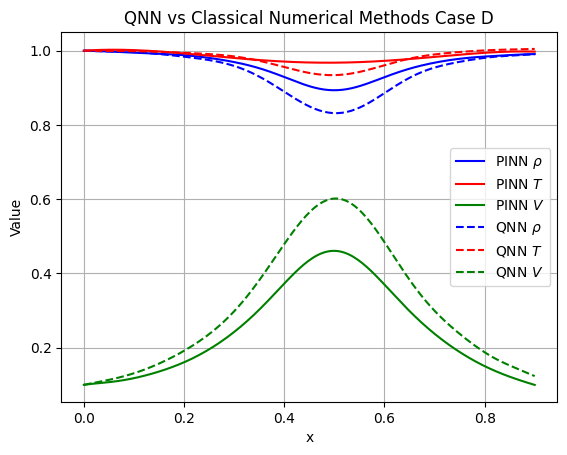

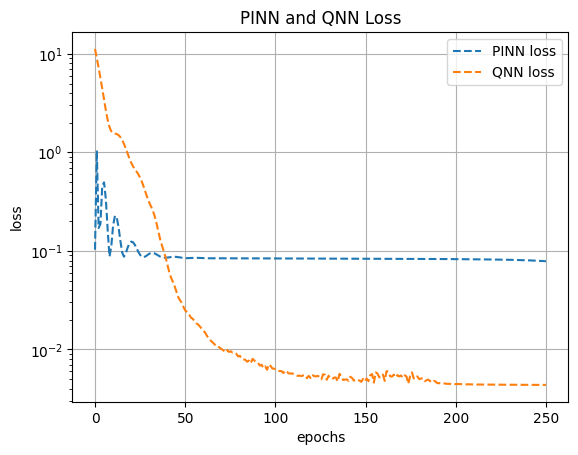

In [ ]:
#experiment D
def f_ns(x, u, gamma=1.4):
    rho, T, V = u[0], u[1], u[2]

    A = 1 + 4.95 * (x - 1)**2
    dlnA_dx = 9.9 * (x - 1) / A

    denom = T - V**2 + 1e-8  

    drho_dx = (rho * V**2 / denom) * dlnA_dx
    dT_dx = (T * V**2 * (gamma - 1) / denom) * dlnA_dx
    dV_dx = - (T * V / denom) * dlnA_dx

    return torch.tensor([drho_dx, dT_dx, dV_dx])

# Classical RK4 method for solving the ODE in Case D
def rk4_ns(u0=torch.tensor([1.0, 1.0, 0.1]), x0=0.0, x_end=1.8, num_points=200, gamma=1.4):
    x_vals = torch.linspace(x0, x_end, num_points)
    h = x_vals[1] - x_vals[0]
    u_vals = torch.zeros(num_points, 3)
    u_vals[0] = u0

    for i in range(1, num_points):
        x_n = x_vals[i-1]
        u_n = u_vals[i-1]

        k1 = h * f_ns(x_n, u_n, gamma)
        k2 = h * f_ns(x_n + h/2, u_n + k1/2, gamma)
        k3 = h * f_ns(x_n + h/2, u_n + k2/2, gamma)
        k4 = h * f_ns(x_n + h, u_n + k3, gamma)

        u_vals[i] = u_n + (k1 + 2*k2 + 2*k3 + k4) / 6

    return  u_vals[:,0], u_vals[:,1], u_vals[:,2]

# Simple explicit finite difference method for Case D
def finite_difference_ns(u0=torch.tensor([1.0, 1.0, 0.1]), x0=0.0, x_end=1.8, num_points=200, gamma=1.4):
    x_vals = torch.linspace(x0, x_end, num_points)
    h = x_vals[1] - x_vals[0]
    u_vals = torch.zeros(num_points, 3)
    u_vals[0] = u0

    for i in range(1, num_points):
        x_n = x_vals[i-1]
        u_n = u_vals[i-1]
        du_dx = f_ns(x_n, u_n, gamma)
        u_vals[i] = u_n + h * du_dx

    return u_vals[:,0], u_vals[:,1], u_vals[:,2]

def make_pinn_loss_fn_ns():
    gamma = 1.4
    def loss_fn(model_rho, model_T, model_V, x):
        x0 = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=True)
        # Initial conditions
        shift_rho = 1.0 - model_rho(x0)
        shift_T = 1.0 - model_T(x0)
        shift_V = 0.1 - model_V(x0)

        # Apply shifts to the model outputs over the domain
        rho = model_rho(x) + shift_rho
        T = model_T(x) + shift_T
        V = model_V(x) + shift_V

        # Compute derivatives using autograd
        drho_dx = torch.autograd.grad(rho, x, grad_outputs=torch.ones_like(rho), create_graph=True)[0]
        dT_dx = torch.autograd.grad(T, x, grad_outputs=torch.ones_like(T), create_graph=True)[0]
        dV_dx = torch.autograd.grad(V, x, grad_outputs=torch.ones_like(V), create_graph=True)[0]

        A = 1 + 4.95 * (2*x - 1)**2
        dlnA_dx = (39.6*x - 19.8)/(4.95*(2*x - 1)**2 + 1)

        denom = T - V**2 + 1e-8  
        # Physics-informed residuals derived from PDE system
        res1 = drho_dx - (rho * V**2 / denom) * dlnA_dx
        res2 = dT_dx - (T * V**2 * (gamma - 1) / denom) * dlnA_dx
        res3 = dV_dx + (T * V / denom) * dlnA_dx
        
        # Mean squared residual loss
        return torch.mean(res1**2 + res2**2 + res3**2)
    return loss_fn


def train_pinn_ns(model_rho, model_T, model_V, loss_fn, epochs=1500, lr=1e-3):
    # Combine parameters from all three models
    plateau_patience=10
    scheduler_eps=1e-10
    clip_th=0.25
    stop_threshold=1e-9
    min_lr=1e-9
    optimizer = torch.optim.Adam(
        list(model_rho.parameters()) + list(model_T.parameters()) + list(model_V.parameters()), lr=lr
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=plateau_patience, factor=0.5, eps=scheduler_eps
    )
    x_train = torch.linspace(0.0, 0.9, 100, dtype=torch.float32).unsqueeze(1).requires_grad_(True)  # <-- requires_grad=True

    losses = []
    theta = []
    progress = trange(epochs, desc="Training", dynamic_ncols=True)
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(model_rho, model_T, model_V, x_train)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_th)
        optimizer.step()
        loss_val = loss.item()
        scheduler.step(loss_val)
        current_lr = optimizer.param_groups[0]['lr']
        losses.append(loss_val)
        theta.append([p.detach().cpu().numpy().copy() for p in model.parameters()])
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
        progress.set_postfix(loss=loss, lr=current_lr)

        if loss_val < stop_threshold:
            print(f"\n Early stopping at epoch {epoch} — loss < {stop_threshold:.1e}")
            break

        # (2) learning rate too small
        if current_lr < min_lr:
            print(f"\n Stopping at epoch {epoch} — learning rate below {min_lr}")
            break


    return losses, x_train

def fine_tune_lbfgs_ns(model_rho, model_T, model_V, loss_fn, x_train, max_iter=500):
    optimizer = torch.optim.LBFGS(
        list(model_rho.parameters()) + list(model_T.parameters()) + list(model_V.parameters()), 
        max_iter=max_iter, 
        line_search_fn='strong_wolfe'
    )

    def closure():
        optimizer.zero_grad()
        loss = loss_fn(model_rho, model_T, model_V, x_train)
        loss.backward()
        return loss

    optimizer.step(closure)

# Plot predictions from PINN, QNN for Case D
def plot_ns_solution_single_plot(model_rho, model_T, model_V, exact_rho=None, exact_T=None, exact_V=None):
    x_test = torch.linspace(0.0, 0.9, 200, dtype=torch.float32).unsqueeze(1)
    with torch.no_grad():
        x0 = torch.tensor([[0.0]], dtype=torch.float32)
        shift_rho = 1.0 - model_rho(x0)
        shift_T = 1.0 - model_T(x0)
        shift_V = 0.1 - model_V(x0)

        rho_pred = (model_rho(x_test) + shift_rho).flatten()
        T_pred = (model_T(x_test) + shift_T).flatten()
        V_pred = (model_V(x_test) + shift_V).flatten()

    with torch.no_grad():
        x0 = torch.tensor([[0.0]], dtype=torch.float32)
        rho_shift = 1.0 - case_d_qnn_model_rho(x0)
        T_shift = 1.0 - case_d_qnn_model_T(x0)
        V_shift = 0.1 - case_d_qnn_model_V(x0)

        qnn_rho = (case_d_qnn_model_rho(x_test) + rho_shift).flatten().detach().numpy()
        qnn_T = (case_d_qnn_model_T(x_test) + T_shift).flatten().detach().numpy()
        qnn_V = (case_d_qnn_model_V(x_test) + V_shift).flatten().detach().numpy()


    plt.plot(x_test.numpy(), rho_pred, label="PINN $\u03C1$", color='blue', linestyle='-')
    plt.plot(x_test.numpy(), T_pred, label="PINN $T$", color='red', linestyle='-')
    plt.plot(x_test.numpy(), V_pred, label="PINN $V$", color='green', linestyle='-')
    plt.plot(x_test.numpy(), qnn_rho, label="QNN $\u03C1$", color='blue', linestyle='--')
    plt.plot(x_test.numpy(), qnn_T, label="QNN $T$", color='red', linestyle='--')
    plt.plot(x_test.numpy(), qnn_V, label="QNN $V$", color='green', linestyle='--')

    plt.xlabel("x")
    plt.ylabel("Value")
    plt.title("QNN vs Classical Numerical Methods Case D")
    plt.legend()
    plt.grid(True)
    plt.show()


model1 = make_pinn_model()
model2 = make_pinn_model()
model3 = make_pinn_model()
loss_fn = make_pinn_loss_fn_ns()
history, x_train = train_pinn_ns(model1, model2, model3, loss_fn, epochs=250)
fine_tune_lbfgs_ns(model1, model2, model3, loss_fn, x_train)
plot_ns_solution_single_plot(model1, model2, model3)
qnn_history_loss = case_d_history_loss["losses"]
plot_pinn_loss(history, qnn_history_loss, 250)


In [207]:
import sympy as sp
x = sp.Symbol('x')
A = 1 + 4.95 * (2*x - 1)**2
print(sp.diff(sp.ln(A), x))


(39.6*x - 19.8)/(4.95*(2*x - 1)**2 + 1)


Training:   0%|          | 0/112 [00:00<?, ?it/s, loss=tensor([[0.0016]], dtype=torch.float32, grad_fn=<AddBackward0>), lr=0.005]

Epoch 0, Loss: 0.826513


Training:   0%|          | 0/112 [00:00<?, ?it/s, loss=tensor([[0.0003]], dtype=torch.float32, grad_fn=<AddBackward0>), lr=0.0025]


Epoch 100, Loss: 0.002159


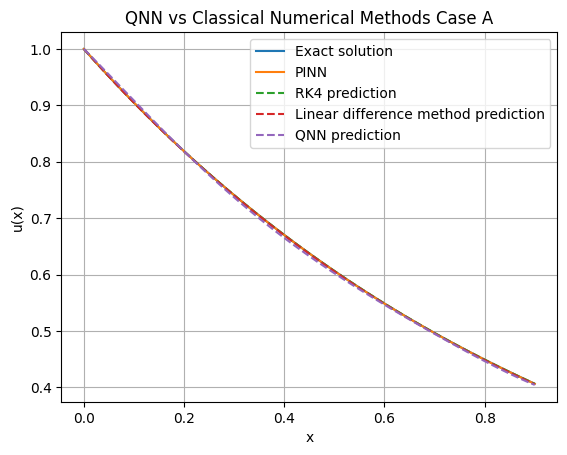

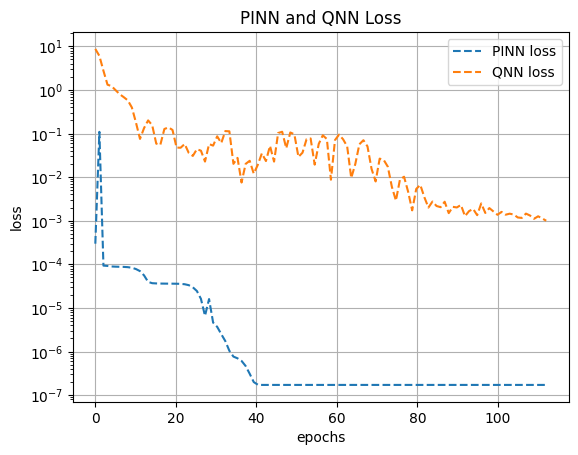

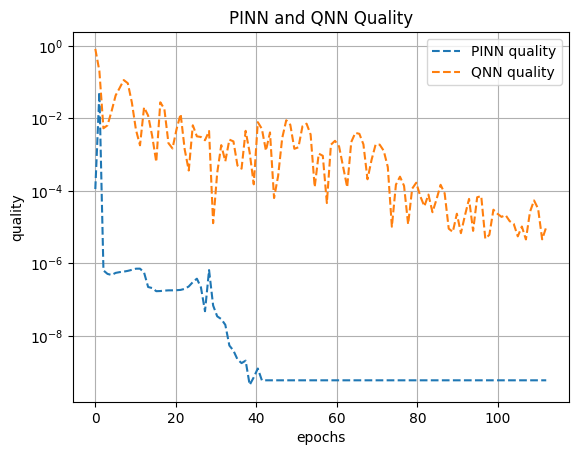

In [ ]:
#experiment 1
# Define the differential equation
def f_lin(x, u):
    return - u 

# Runge-Kutta 4th order method for solving ODE
def rk4_lin(u0=1.0, x0=0.0, x_end=0.9, num_points=200):
    x_vals = torch.linspace(x0, x_end, num_points) # Generate grid points
    h = x_vals[1] - x_vals[0] # Step size
    u_vals = torch.zeros_like(x_vals)
    u_vals[0] = u0 # Initial condition

    # Iterate using RK4 scheme
    for i in range(1, num_points):
        x_n = x_vals[i-1]
        u_n = u_vals[i-1]

        k1 = h * f_lin(x_n, u_n)
        k2 = h * f_lin(x_n + h/2, u_n + k1/2)
        k3 = h * f_lin(x_n + h/2, u_n + k2/2)
        k4 = h * f_lin(x_n + h, u_n + k3)

        u_vals[i] = u_n + (k1 + 2*k2 + 2*k3 + k4) / 6 # Update solution

    return x_vals, u_vals

# Simple finite difference method (Euler forward)
def finite_difference_method_lin(u0=1.0, x0=0.0, x_end=0.9, num_points=200):
    x_vals = torch.linspace(x0, x_end, num_points)
    h = x_vals[1] - x_vals[0]
    u_vals = torch.zeros_like(x_vals)
    u_vals[0] = u0 # Initial condition

    # Iterate using forward Euler method
    for i in range(1, num_points):
        x_n = x_vals[i-1]
        u_n = u_vals[i-1]
        u_vals[i] = h*f_lin(x_n + h, u_n) + u_n # Euler step

    return x_vals, u_vals

# Create the loss function for the PINN
def make_pinn_loss_lin():
    def loss_fn(model, x):
        # Normalize input and enable gradient tracking
        x_norm = x.clone().detach().requires_grad_(True).float()
        u = model(x_norm)

        # Compute du/dx via autograd
        du_dx = torch.autograd.grad(
            outputs=u,
            inputs=x_norm,
            grad_outputs=torch.ones_like(u),
            create_graph=True
        )[0]

        # Define the residual of the PDE
        residual = du_dx + u

        # Enforce initial condition u(0) = 1
        x0 = torch.tensor([[0.0]], dtype=torch.float32)
        x0_= x0.requires_grad_(True)
        u0 = model(x0_)
        ic_loss = (u0 - 1.0) ** 2

        # Total loss = PDE residual + initial condition penalty
        return torch.mean(residual**2) + ic_loss
    return loss_fn

# Plot PINN and classical methods vs exact solution
def plot_solution_lin(model, qnn_model):
    x_test = torch.linspace(0.0, 0.9, 200, dtype=torch.float32).unsqueeze(1)
    with torch.no_grad():
        u_pred = model(x_test).flatten()
    u_exact = f_exact(x_test).flatten()

    x_rk4, u_rk4 = rk4_lin()
    x_fd, u_fd = finite_difference_method_lin()

    with torch.no_grad():
        y_model_qnn = qnn_model(x_test).flatten()
        x0_qnn = torch.tensor([[0.0]],dtype=torch.float32)
        shift = 1.0 - qnn_model(x0_qnn).item()
        y_model_shifted = y_model_qnn + shift

    plt.plot(x_rk4.numpy(), u_exact.numpy(), label="Exact solution")
    plt.plot(x_test.numpy(), u_pred.numpy(), '-', label="PINN")
    plt.plot(x_rk4.numpy(), u_rk4.numpy(), "--", label="RK4 prediction")
    plt.plot(x_fd.numpy(), u_fd.numpy(), "--", label="Linear difference method prediction")
    plt.plot(x_test.numpy().flatten(), y_model_shifted.numpy(), "--", label="QNN prediction")
    plt.xlabel("x")
    plt.ylabel("u(x)")
    plt.legend()
    plt.grid(True)
    plt.title("QNN vs Classical Numerical Methods Case A")
    plt.show()

def compute_pinn_solution_quality_lin(theta, x_test):
    quality = []
    for params in theta:
        # Recreate a fresh model with same architecture
        model = make_pinn_model()
        # Load parameters
        with torch.no_grad():
            for p, p_val in zip(model.parameters(), params):
                p.copy_(torch.tensor(p_val))
        # Get prediction
        with torch.no_grad():
            u_pred = model(x_test).flatten()
        # Get exact solution
        u_exact = f_exact(x_test).flatten()
        # Compute MSE (or L2 error) as quality
        error = torch.mean((u_pred - u_exact)**2).item()
        quality.append(error)

    return quality

def compute_qnn_solution_quality_lin(theta_log, fmap, ansatz, observable, n_qubits, x_test):
    quality = []

    # Build empty QNN structure to load weights into each epoch
    base_model, _ = make_model(fmap, ansatz, observable, n_qubits)

    for theta in theta_log:
        # Reset model with copied weights
        with torch.no_grad():
            for p, p_val in zip(base_model.parameters(), theta):
                p.copy_(torch.tensor(p_val))

        # Predict
        with torch.no_grad():
            u_pred = base_model(x_test).flatten()

        # Apply shift for boundary condition (u(0) = 1)
        x0 = torch.tensor([[0.0]], dtype=torch.float32)
        shift = 1.0 - base_model(x0).item()
        u_pred_shifted = u_pred + shift

        # Ground truth
        u_exact = f_exact(x_test).flatten()

        # Quality (MSE)
        error = torch.mean((u_pred_shifted - u_exact)**2).item()
        quality.append(error)

    return quality


# Train and plot results
model = make_pinn_model()
loss_fn = make_pinn_loss_lin()
theta, history, x_train = train(model, loss_fn, epochs=112)
theta, loss = fine_tune_lbfgs2(model, loss_fn, x_train, epochs = 112)
fine_tune_lbfgs(model, loss_fn, x_train, epochs = 112)
plot_solution_lin(model, model_lin)
qnn_history_loss = lin_history["losses"]
plot_pinn_loss(loss, qnn_history_loss, 112)

theta_qnn = lin_history["thetas"]  # from your QNN
x_test = torch.linspace(0.0, 0.9, 200, dtype=torch.float32).unsqueeze(1)

# Create circuits again with same settings used in training
fmap = make_feature_map(n_qubits=3)
ansatz = make_ansatz(n_qubits=3, depth=3)
observable = make_observable(n_qubits=3)
# Compute quality
qnn_t = compute_qnn_solution_quality_lin(theta_qnn, fmap, ansatz, observable, 3, x_test)

t = compute_pinn_solution_quality_lin(theta, x_test)

plot_pinn_quality(t, qnn_t, 112)

Training:   0%|          | 0/250 [00:00<?, ?it/s, loss=tensor([[0.1510]], dtype=torch.float32, grad_fn=<AddBackward0>), lr=0.005]

Epoch 0, Loss: 13.408706


Training:   0%|          | 0/250 [00:00<?, ?it/s, loss=tensor([[0.0231]], dtype=torch.float32, grad_fn=<AddBackward0>), lr=0.0025]

Epoch 100, Loss: 0.158437


Training:   0%|          | 0/250 [00:00<?, ?it/s, loss=tensor([[0.0020]], dtype=torch.float32, grad_fn=<AddBackward0>), lr=0.00125]


Epoch 200, Loss: 0.010316


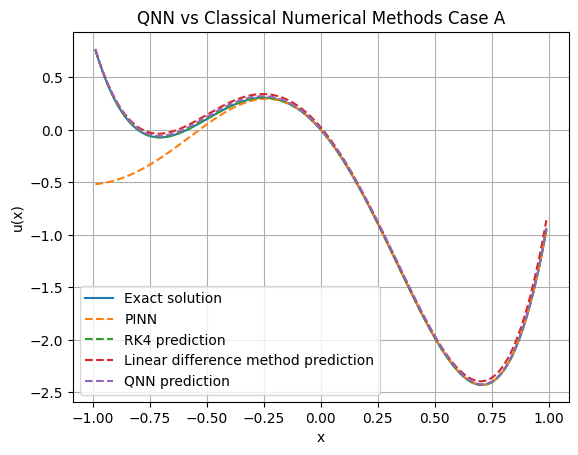

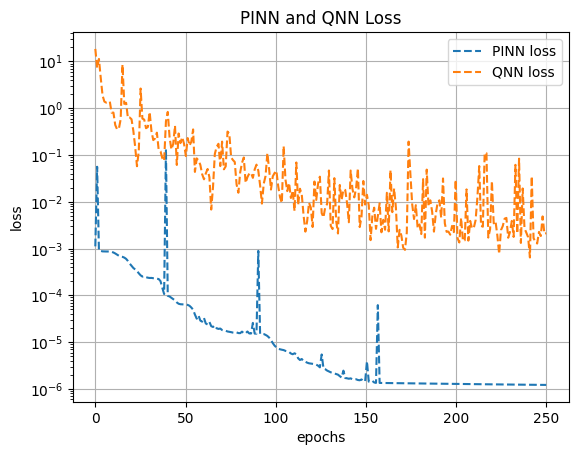

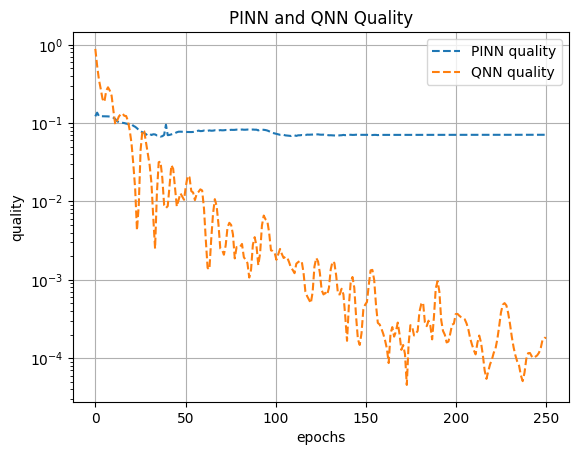

In [ ]:
#experiment 2
# Define the differential equation
def f_poly(x, u):
    return 5 * (4 * x**3 + x**2 - 2 * x - 0.5)

# Runge-Kutta 4th order method for solving ODE
def rk4_poly(u0=0.0, x0=-0.99, x_end=0.99, num_points=200):
    x_vals = torch.linspace(x0, x_end, num_points) # Generate grid points
    h = x_vals[1] - x_vals[0] # Step size
    u_vals = torch.zeros_like(x_vals)
    u0 = f_exact(x0)
    u_vals[0] = u0 # Initial condition

    # Iterate using RK4 scheme
    for i in range(1, num_points):
        x_n = x_vals[i-1]
        u_n = u_vals[i-1]

        k1 = h * f_poly(x_n, u_n)
        k2 = h * f_poly(x_n + h/2, u_n + k1/2)
        k3 = h * f_poly(x_n + h/2, u_n + k2/2)
        k4 = h * f_poly(x_n + h, u_n + k3)

        u_vals[i] = u_n + (k1 + 2*k2 + 2*k3 + k4) / 6 # Update solution

    return x_vals, u_vals

# Simple finite difference method (Euler forward)
def finite_difference_method_poly(u0=0.0, x0=-0.99, x_end=0.99, num_points=200):
    x_vals = torch.linspace(x0, x_end, num_points)
    h = x_vals[1] - x_vals[0]
    u0 = f_exact(x0)
    u_vals = torch.zeros_like(x_vals)
    u_vals[0] = u0 # Initial condition

    # Iterate using forward Euler method
    for i in range(1, num_points):
        x_n = x_vals[i-1]
        u_n = u_vals[i-1]
        u_vals[i] = h*f_poly(x_n + h, u_n) + u_n # Euler step

    return x_vals, u_vals
    

# Create the loss function for the PINN
def make_pinn_loss_poly():
    def f_rhs(x):  # RHS of df/dx
        return 5 * (4 * x**3 + x**2 - 2 * x - 0.5)

    def loss_fn(model, x):
        x = x.clone().detach().requires_grad_(True)
        u = model(x)

        # Compute derivative du/dx via autograd
        du_dx = torch.autograd.grad(
            outputs=u,
            inputs=x,
            grad_outputs=torch.ones_like(u),
            create_graph=True
        )[0]

        # ODE loss: compare du/dx to known RHS
        ode_loss = torch.mean((du_dx - f_rhs(x))**2)

        # Boundary condition: u(0) = 0
        x0 = torch.tensor([[0.0]], requires_grad=True).float()
        u0 = model(x0).float()
        bc_loss = (u0 - 0.0)**2

        return ode_loss + bc_loss

    return loss_fn

# Plot PINN and classical methods vs exact solution
def plot_solution_poly(model, qnn_model):
    x_test = torch.linspace(-0.99, 0.99, 200, dtype=torch.float32).unsqueeze(1)
    with torch.no_grad():
        u_pred = model(x_test).flatten()
        
    u_exact = f_exact2(x_test).flatten()

    x_rk4, u_rk4 = rk4_poly()
    x_fd, u_fd = finite_difference_method_poly()

    with torch.no_grad():
        y_model_qnn = qnn_model(x_test).detach().flatten()

    plt.plot(x_rk4.numpy(), u_exact.numpy(), label="Exact solution")
    plt.plot(x_test.numpy(), u_pred.numpy(), '--', label="PINN")
    plt.plot(x_rk4.numpy(), u_rk4.numpy(), "--", label="RK4 prediction")
    plt.plot(x_fd.numpy(), u_fd.numpy(), "--", label="Linear difference method prediction")
    plt.plot(x_test.numpy().flatten(), y_model_qnn.numpy(), "--", label="QNN prediction")
    plt.xlabel("x")
    plt.ylabel("u(x)")
    plt.legend()
    plt.grid(True)
    plt.title("QNN vs Classical Numerical Methods Case A")
    plt.show()

def compute_pinn_solution_quality_poly(theta, x_test):
    quality = []
    for params in theta:
        # Recreate a fresh model with same architecture
        model = make_pinn_model()
        # Load parameters
        with torch.no_grad():
            for p, p_val in zip(model.parameters(), params):
                p.copy_(torch.tensor(p_val))
        # Get prediction
        with torch.no_grad():
            u_pred = model(x_test).flatten().float()
        # Get exact solution
        u_exact = f_exact(x_test).flatten()
        # Compute MSE (or L2 error) as quality
        error = torch.mean((u_pred - u_exact)**2).item()
        quality.append(error)

    return quality

def compute_qnn_solution_quality_poly(theta_log, fmap, ansatz, observable, n_qubits, x_test):
    quality = []
    base_model, _ = make_model(fmap, ansatz, observable, n_qubits)

    for theta in theta_log:
        # Load weights into base_model
        with torch.no_grad():
            for p, p_val in zip(base_model.parameters(), theta):
                p.copy_(torch.tensor(p_val))

        with torch.no_grad():
            u_pred = base_model(x_test).flatten()

        # Evaluate MSE (no post-shift!)
        u_exact = f_exact2(x_test).flatten()
        mse = torch.mean((u_pred - u_exact)**2).item()
        quality.append(mse)

    return quality


# Train and plot results
model = make_pinn_model()
loss_fn = make_pinn_loss_poly()
theta, history, x_train = train(model, loss_fn, epochs=250)
theta, loss = fine_tune_lbfgs2(model, loss_fn, x_train, epochs=250)
fine_tune_lbfgs(model, loss_fn, x_train, epochs=250)
plot_solution_poly(model, model_poly)
qnn_history_loss = poly_history["losses"]
plot_pinn_loss(loss, qnn_history_loss, 250)

theta_qnn = poly_history["thetas"]  # from your QNN
x_test = torch.linspace(-0.99, 0.99, 200, dtype=torch.float32).unsqueeze(1)

# Create circuits again with same settings used in training
fmap = make_feature_map(n_qubits=3)
ansatz = make_ansatz(n_qubits=3, depth=3)
observable = make_observable(n_qubits=3)
# Compute quality
qnn_t = compute_qnn_solution_quality_poly(theta_qnn, fmap, ansatz, observable, 3, x_test)

t = compute_pinn_solution_quality_poly(theta, x_test)

plot_pinn_quality(t, qnn_t, 250)

# Repair Project

the plan:

- Case B (highly nontrivial dynamics)
1. Grid search or smth smarter for QNN: Train and Evaluate QNN on different set of parameters (qubits/depth), fixed num. epochs 250 for all. Make a heat map (color - solution quality, x/y - qubits/depth)
2. Same but can try with regularization, will it result is same quality with less resources?
3. Take optimal set from previous step, initialise a PINN with same number of trainable parameters. Compare convergence (loss), quality of solution, time taken per epoch
4. Change the backend to a noisy simulator, train optimal qnn and compare to the same optimal qnn but using different error mitigation techniques (mitiq?). Compare again based on convergence, quality, time.
